# 14-9. 프로젝트 : 주식 예측에 도전해 보자

ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다.

데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.

Yahoo Finance (https://finance.yahoo.com/?guccounter=1) 에서 오늘 사용할 데이터셋을 다운로드할 수 있습니다.

하지만 이전 스텝을 차근차근 진행하셨다면, 이미 데이터셋이 stock_prediction/data 에 올라와 있을 것입니다.

아래 명령어로 005930.KS.csv 파일이 존재하는지 확인해봐요.

- cd ~/aiffel/stock_prediction/data
- ls

만약 해당 파일이 없다면 다음과 같이 실행해주세요.

- mkdir -p ~/aiffel/stock_prediction/data  # 이 디렉토리를 만들지 않았을 경우에만 실행해주세요
- ln -s ~/data/* ~/aiffel/stock_prediction/data

이후 순서는 다음과 같습니다. 필요한 내용은 이미 앞에서 다 다루었기 때문에 이후 과정은 여러분들이 직접 수행해 보시기를 바랍니다.

### 목차

    STEP 1. 시계열 데이터 준비
    STEP 2. 각종 전처리 수행
    STEP 3. 시계열 안정성 분석
    STEP 4. 학습, 테스트 데이터셋 생성
    STEP 5. 적정 ARIMA 모수 찾기
    STEP 6. ARIMA 모델 훈련과 테스트
    STEP 7. 다른 주식 종목 예측해 보기
    STEP 8. 회고

## STEP 1. 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-11-17    65700.0
2020-11-18    64800.0
2020-11-19    64600.0
2020-11-20    64700.0
2020-11-23    67500.0
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

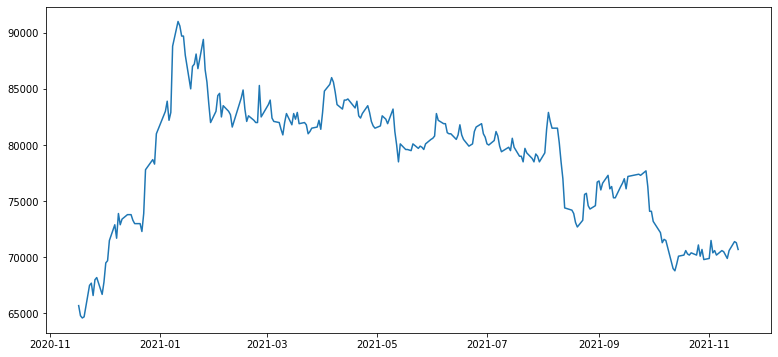

In [2]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [3]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

isna 로 확인 하였으나, 결측치가 없음을 확인 할 수 있습니다.

혹시라도 결측치가 있다면 두가지 방법으로 처리가 가능합니다.

1. 결측치가 있는 데이터를 모두 삭제(drop)

2. 결측치 양옆의 값들을 이용해서 적절히 보간(interpolate)하여 대입
    ex) 2와 4 사이 데이터가 NaN이라면 이 값을 3으로 채우는 방식

이번 경우엔 시간을 index로 가지는 시계열 데이터이므로 삭제하는 것보다는 보간하는 방법을 선택하는 것이 낫습니다.

Series([], Name: Close, dtype: float64)


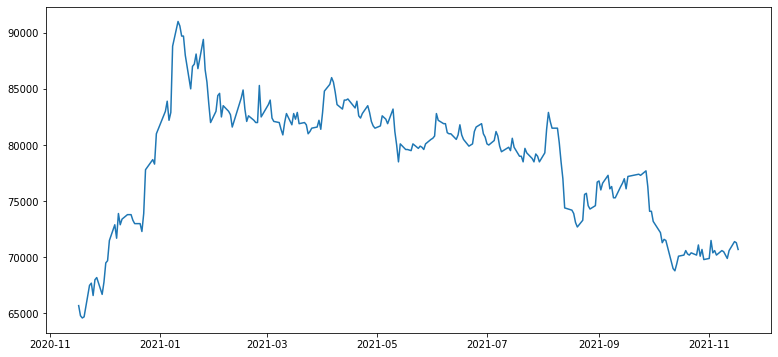

In [4]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

- 결측치가 없어서 위의 그래프와 모양이 다르지 않습니다.

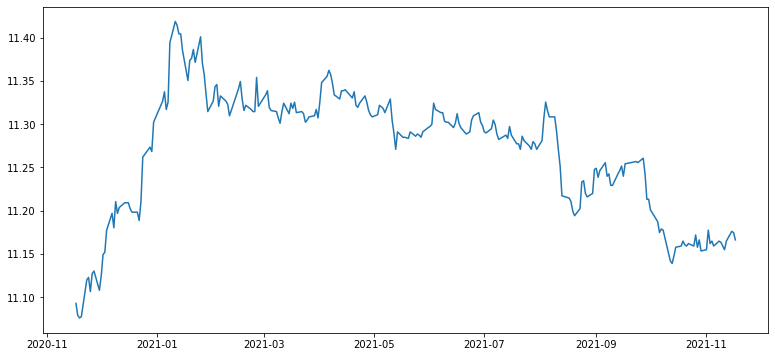

In [6]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

- log 변환을 통해서 90,000에 근접하던 차트의 최대값이 11.4 이하의 값으로 변환 되었음을 확인 할 수 있습니다.

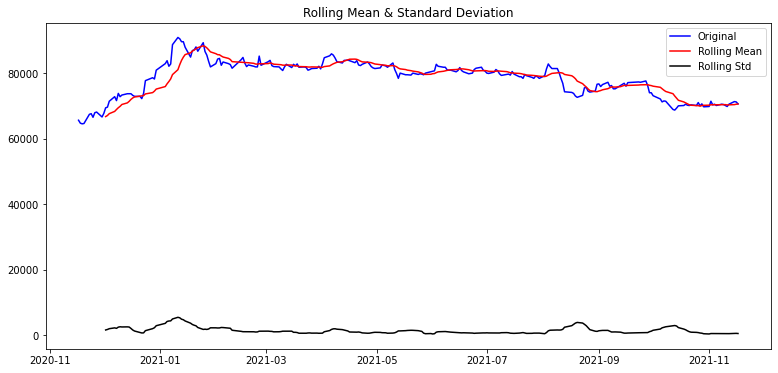

In [7]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# window = 12 (이동평균 = 12)일 때, 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 12)

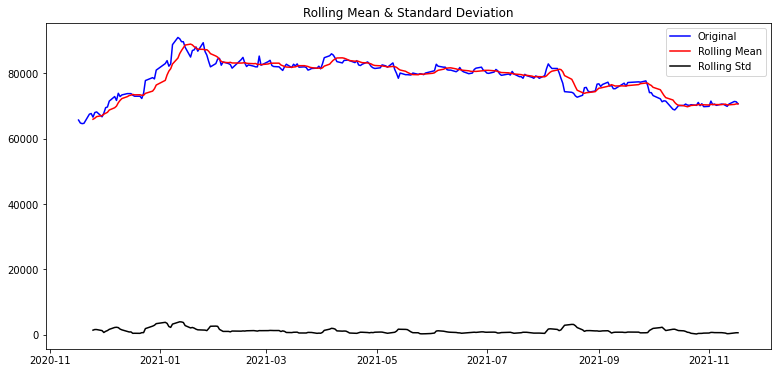

In [8]:
# window = 7 (이동평균 = 7, 1주)일 때, 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 7)

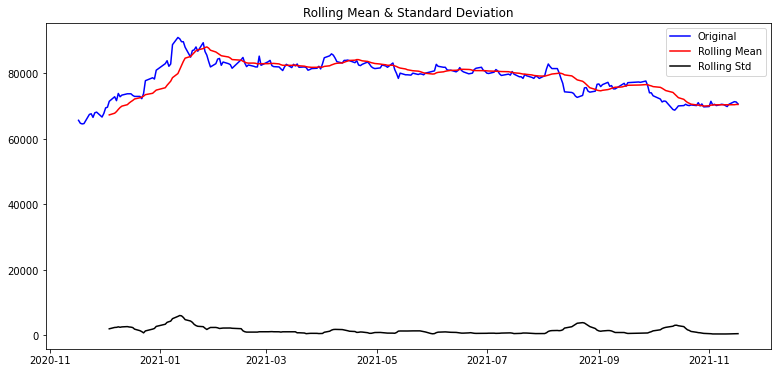

In [9]:
# window = 14 (이동평균 = 14, 2주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 14)

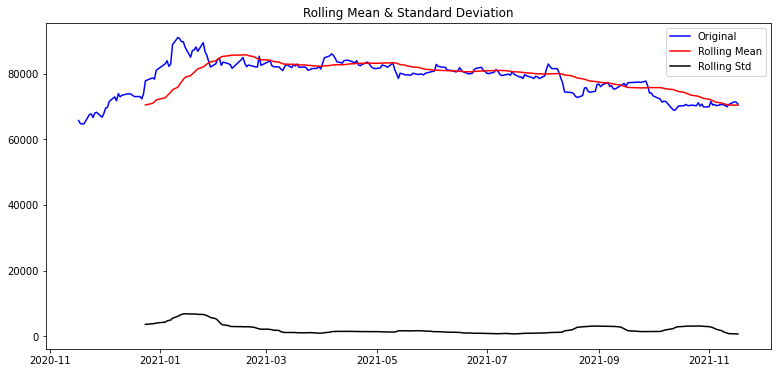

In [10]:
# window = 28 (이동평균 = 28, 4주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 28)

In [11]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                  -1.901968
p-value                          0.331136
#Lags Used                      12.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


cf) p-value(유의확률)이란?

p-value의 정의는 귀무가설을 가정했을 때의 확률분포 상에서 현재의 관측보다 더 극단적인 관측이 나올 확률로서, 귀무가설의 가정이 틀렸다고 볼 수 있는 확률이기도 합니다.

이 값이 0.05 미만으로 매우 낮게 나온다면 p-value만큼의 오류 가능성 하에 귀무가설을 기각하고 대립가설을 채택할 수 있는 근거가 될 수 있습니다.

반대로 말하자면, p-value가 1에 가깝다는 것이 이 귀무가설(주어진 시계열 데이터가 안정적이지 않다.) 이 옳다는 직접적인 증거는 아닙니다.

하지만 이 귀무가설을 기각할 수는 없게 되었으므로 이 시계열이 안정적인 시계열이라고 말할 수는 없습니다.

- 그러므로, 초기 p-value 값이 0.331로, 수치를 줄이기 위한 다양한 시도가 필요할 것으로 보입니다.

### 2-1. 로그 함수 변환
---

In [12]:
augmented_dickey_fuller_test(ts_log) # 로그 변화 후

Results of Dickey-Fuller Test:
Test Statistic                  -2.194824
p-value                          0.208129
#Lags Used                       0.000000
Number of Observations Used    247.000000
Critical Value (1%)             -3.457105
Critical Value (5%)             -2.873314
Critical Value (10%)            -2.573044
dtype: float64


- 우선 로그 변환을 함으로서, p-value 가 0.13 정도 감소한 0.208 이 되었음을 확인 할 수 있었습니다.

- 하지만, 아직은 귀무가설을 기각할 수 있을 정도는 아닌 것을 확인 할 수 있습니다.

### 2-2. Moving average 제거 - 추세(Trend) 상쇄하기
---

- 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다.

- 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주도록 하겠습니다.

#### (1) window=7 일 때, Moving average 제거

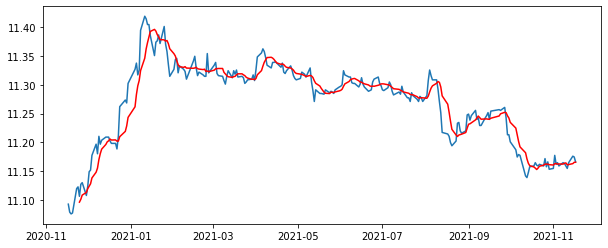

In [13]:
# 기존 그래프와 moving_avg7 시각화
moving_avg7 = ts_log.rolling(window=7).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg7, color='red')

In [14]:
# 변화량, 결측치 제거 후, ts_log_moving_avg7 데이터 확인
ts_log_moving_avg7 = ts_log - moving_avg7 # 변화량 제거
ts_log_moving_avg7.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg7.head(10)

Date
2020-11-25    0.010091
2020-11-26    0.025978
2020-11-27    0.021609
2020-11-30   -0.005200
2020-12-01    0.004471
2020-12-02    0.025064
2020-12-03    0.023779
2020-12-04    0.039134
2020-12-07    0.048585
2020-12-08    0.024838
Name: Close, dtype: float64

이전 스텝에서 정의했던 메소드들을 활용하여 ts_log_moving_avg를 정성, 정량적으로 분석을 진행합니다.

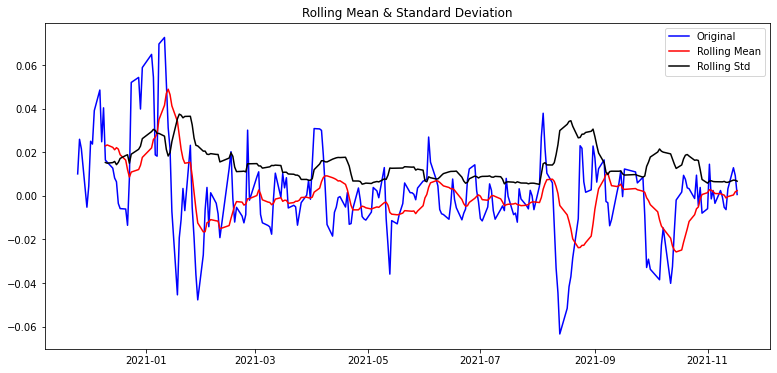

In [15]:
# log 변환 후, log_moving_avg7 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg7)

In [16]:
# log_moving_avg7 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg7)

Results of Dickey-Fuller Test:
Test Statistic                  -3.363766
p-value                          0.012258
#Lags Used                      12.000000
Number of Observations Used    229.000000
Critical Value (1%)             -3.459233
Critical Value (5%)             -2.874245
Critical Value (10%)            -2.573541
dtype: float64


- 드디어 p-value 가 0.0122로 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있습니다.

#### (2) window=14 일 때, Moving average 제거

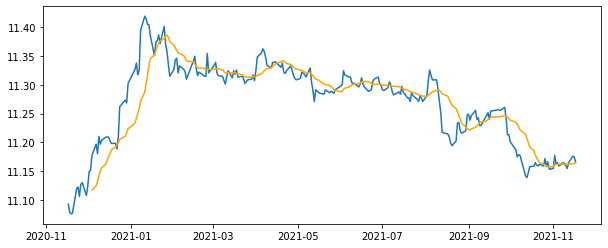

In [17]:
# 기존 그래프와 moving_avg14 시각화
moving_avg14= ts_log.rolling(window=14).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg14, color='orange')

In [18]:
# 변화량, 결측치 제거 후, ts_log_moving_avg14 데이터 확인
ts_log_moving_avg14 = ts_log - moving_avg14 # 변화량 제거
ts_log_moving_avg14.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg14.head(10)

Date
2020-12-04    0.060109
2020-12-07    0.072072
2020-12-08    0.048247
2020-12-09    0.068862
2020-12-10    0.046714
2020-12-11    0.047564
2020-12-14    0.046836
2020-12-15    0.039504
2020-12-16    0.033658
2020-12-17    0.021708
Name: Close, dtype: float64

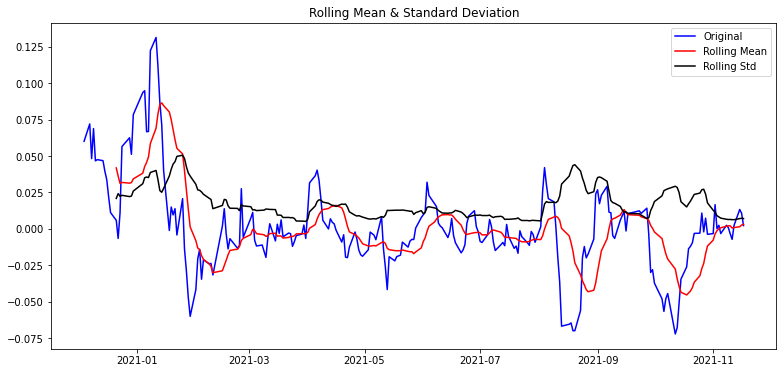

In [19]:
# log 변환 후, log_moving_avg14 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg14)

In [20]:
# log_moving_avg14 의 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg14)

Results of Dickey-Fuller Test:
Test Statistic                  -2.603160
p-value                          0.092346
#Lags Used                      12.000000
Number of Observations Used    222.000000
Critical Value (1%)             -3.460154
Critical Value (5%)             -2.874649
Critical Value (10%)            -2.573757
dtype: float64


- log_moving_avg14 의 p-value 가 0.092346 로 앞에서 본 log_moving_avg7 의 p-value 는 0.0122보다 높으므로, log_moving_avg14은 배제하도록 합니다.

#### (3) window=28 일 때, Moving average 제거
----

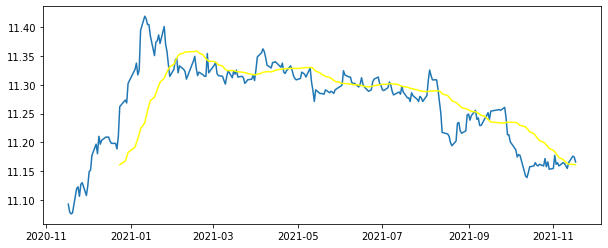

In [21]:
# 기존 그래프와 moving_avg28 시각화
moving_avg28 = ts_log.rolling(window=28).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg28, color='yellow')

In [22]:
# 변화량, 결측치 제거 후, ts_log_moving_avg28 데이터 확인
ts_log_moving_avg28 = ts_log - moving_avg28 # 변화량 제거
ts_log_moving_avg28.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg28.head(10)

Date
2020-12-24    0.100542
2020-12-28    0.105596
2020-12-29    0.093742
2020-12-30    0.119563
2021-01-04    0.135059
2021-01-05    0.138076
2021-01-06    0.110675
2021-01-07    0.111336
2021-01-08    0.170556
2021-01-11    0.184728
Name: Close, dtype: float64

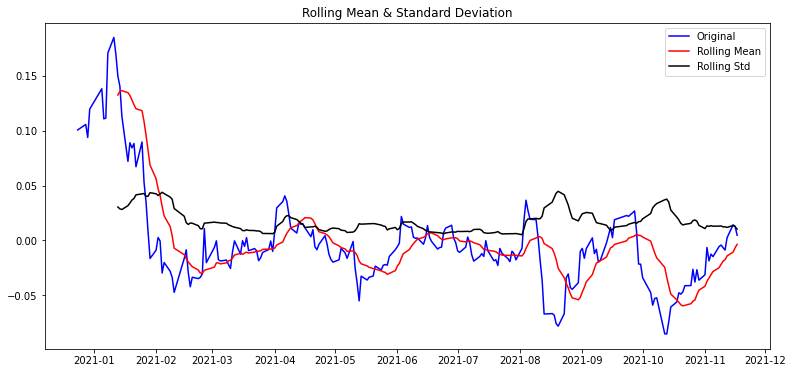

In [23]:
# log 변환 후, log_moving_avg14 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg28)

In [24]:
# log_moving_avg28 의 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg28)

Results of Dickey-Fuller Test:
Test Statistic                  -2.819680
p-value                          0.055517
#Lags Used                       0.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


- log_moving_avg28 의 p-value 가 0.055517 로 앞에서 본 log_moving_avg7 의 p-value 는 0.0122보다 높으므로, log_moving_avg28은 배제하도록 합니다.

### 2-3 차분(Differencing) - 계절성(Seasonality) 상쇄하기
---
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.

- 이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있습니다. 마치 미분(Differentiation)을 떠올리게 하는 개념인데요, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법입니다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됩니다. 이 변화량 시계열은 어떤 패턴을 보이게 될 지 확인해 봅시다.

- 우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보겠습니다.

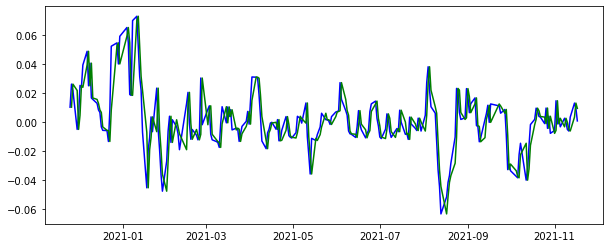

In [25]:
# log_moving_avg7 과 log_moving_avg7를 시프트한 시계열 그래프 시각화
ts_log_moving_avg_shift = ts_log_moving_avg7.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg7, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현해 봅시다.

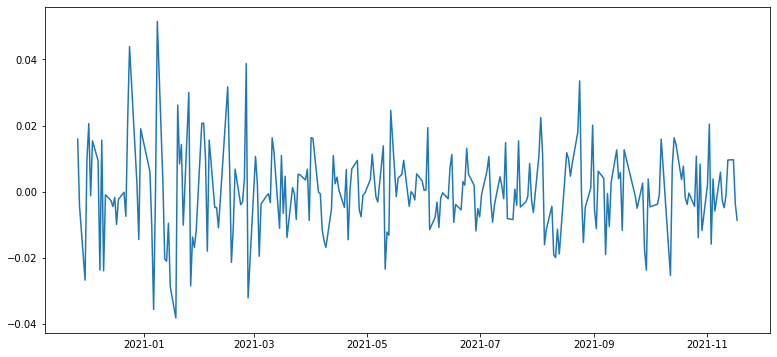

In [27]:
ts_log_moving_avg_diff = ts_log_moving_avg7 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

## STEP 3. 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 3-1. 정성적 그래프 분석

- 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악

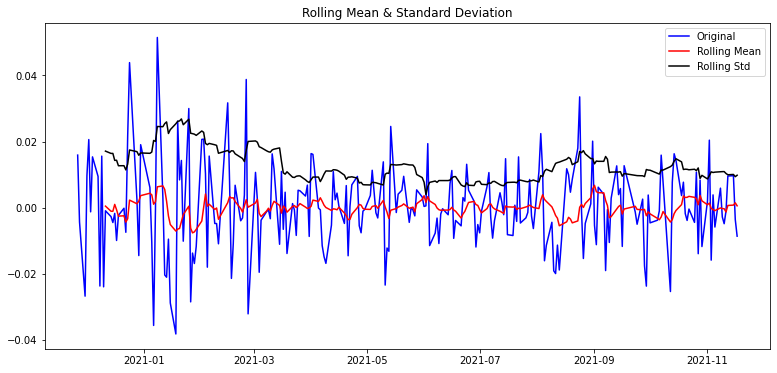

In [28]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

### 3-2. 정량적 Augmented Dicky-Fuller Test
- 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행

In [29]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -7.720622e+00
p-value                        1.195347e-11
#Lags Used                     1.100000e+01
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가

1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과,

p-value가 약  0.0122 에서 1.195347e-11 로 매우 작은 값으로 줄었음을 확인 할 수 있습니다.

### 3-3. 시계열 분해(Time Series Decomposition)

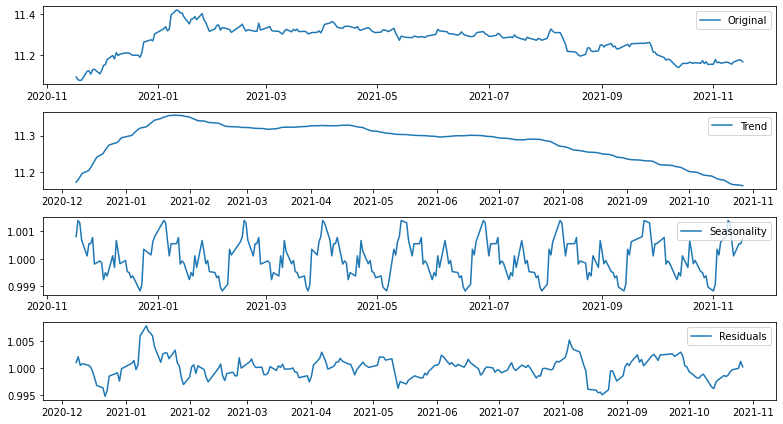

In [30]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. 뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다.

이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

### 3-4. Residual 안정성 확인

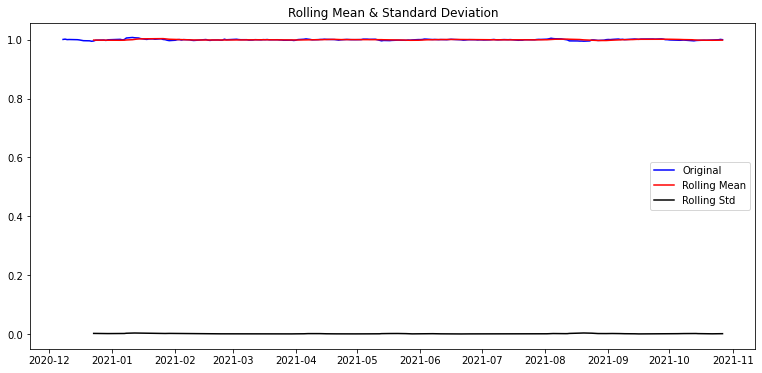

In [31]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [32]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.131365e+00
p-value                        8.386441e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.080000e+02
Critical Value (1%)           -3.462186e+00
Critical Value (5%)           -2.875538e+00
Critical Value (10%)          -2.574231e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다.

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까 싶긴 하겠다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 할 수 있겠습니다.

## STEP 4. 학습, 테스트 데이터셋 생성
---
- 학습, 테스트 데이터셋을 9 : 1 비율로 분리

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [34]:
print(len(train_data))
print(len(test_data))

223
25


학습 데이터와 테스트 데이터가 223, 25개로 분리 되었음을 확인 할 수 있습니다.

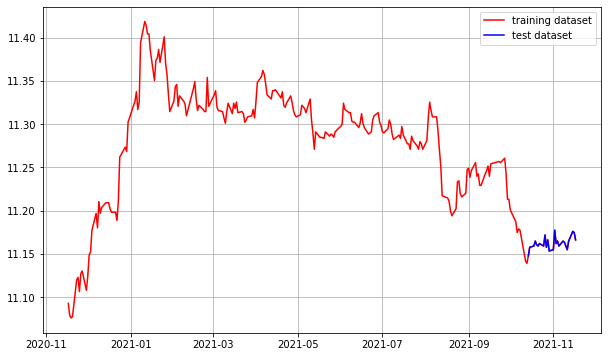

In [35]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

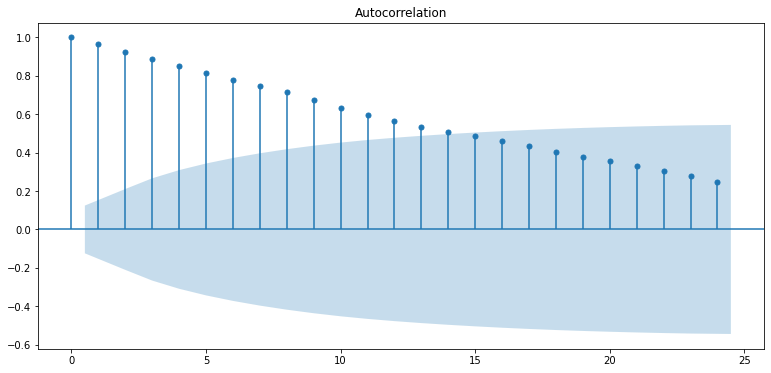

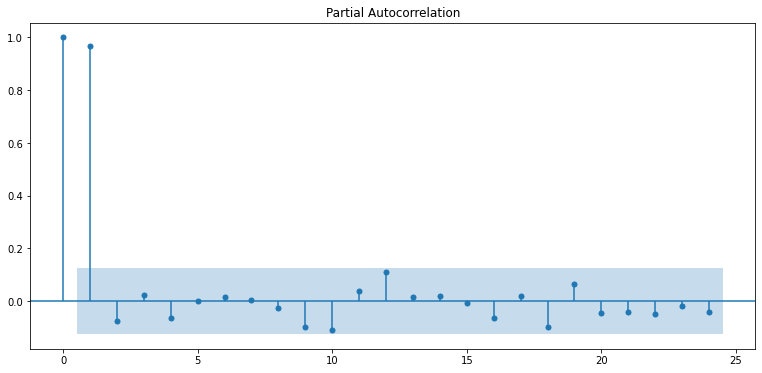

In [36]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위의 그래프의 결론을 내려보자면,

- ACF 그래프를 보면,1에서 25로 갈수록 1에서 0.2로 수렴함을 확인 할 수 있으므로, 적합한 q(MA 모델의 시차) 값이 없을 것 같습니다. 우선 q = 0 으로 진행해 보겠습니다.

- PACF 그래프를 보면 p (AR 모델의 시차) = 1 이 매우 적합할 것으로 보입니다. P가 2 이상인 구간에서 PACF는 거의 0에 가까워 지고 있기 때문입니다. (PACF가 0 이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.)

Results of Dickey-Fuller Test:
Test Statistic                  -4.924942
p-value                          0.000031
#Lags Used                      11.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64


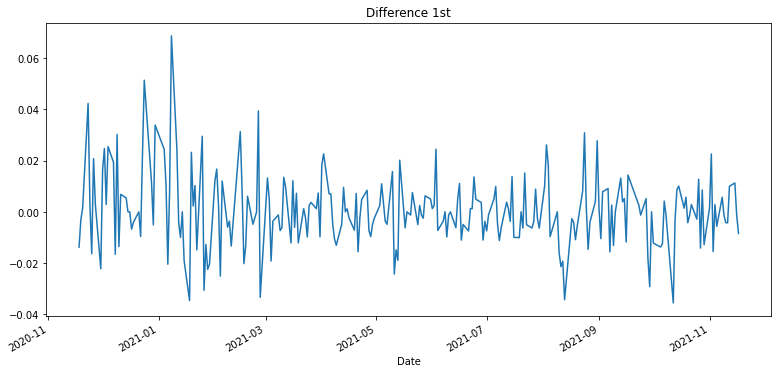

In [37]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

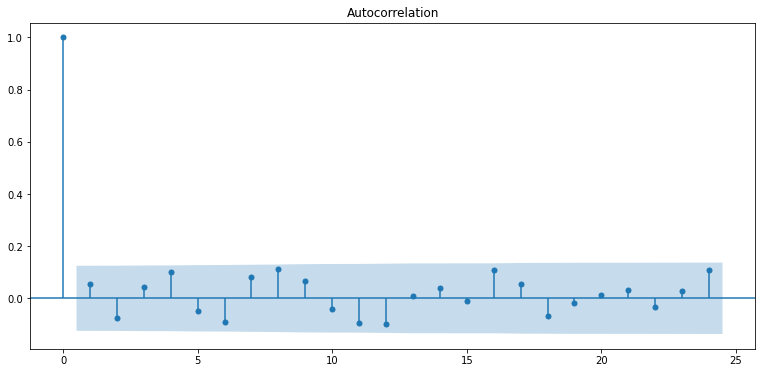

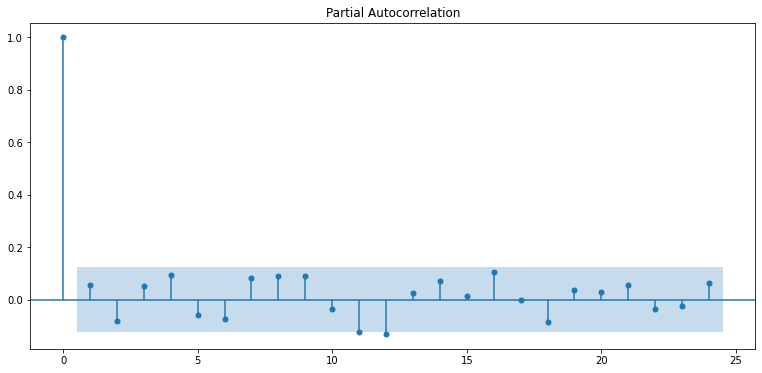

In [38]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.457000e+00
p-value                        5.478890e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


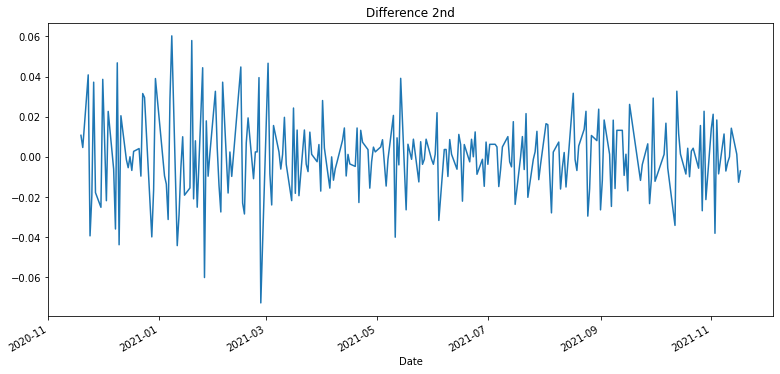

In [39]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

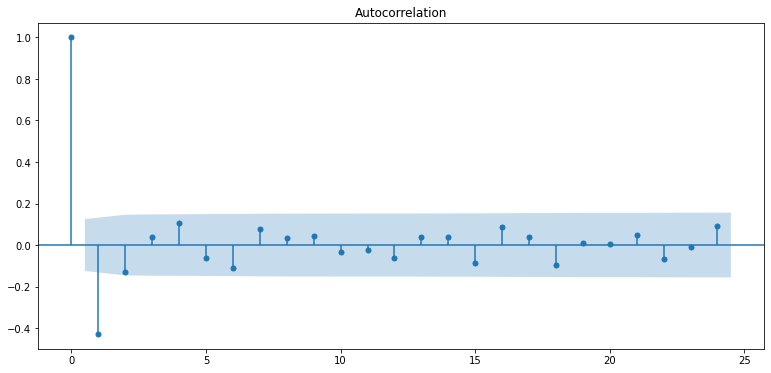

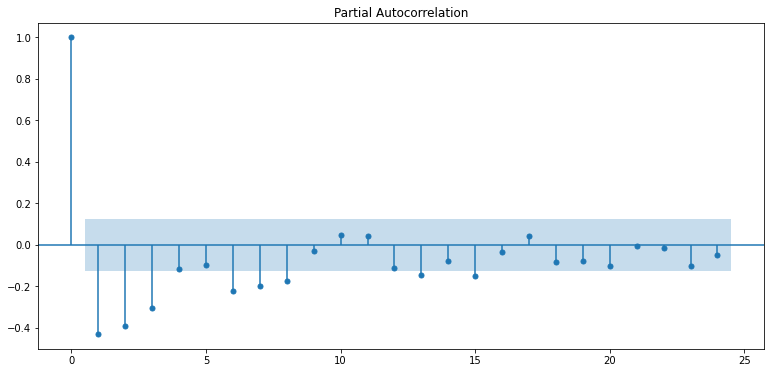

In [40]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -4.924942
p-value                          0.000031
#Lags Used                      11.000000
Number of Observations Used    235.000000
Critical Value (1%)             -3.458487
Critical Value (5%)             -2.873919
Critical Value (10%)            -2.573367
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.457000e+00
p-value                        5.478890e-11
#Lags Used                     1.400000e+01
Number of Observations Used    2.310000e+02
Critical Value (1%)           -3.458980e+00
Critical Value (5%)           -2.874135e+00
Critical Value (10%)          -2.573482e+00
dtype: float64


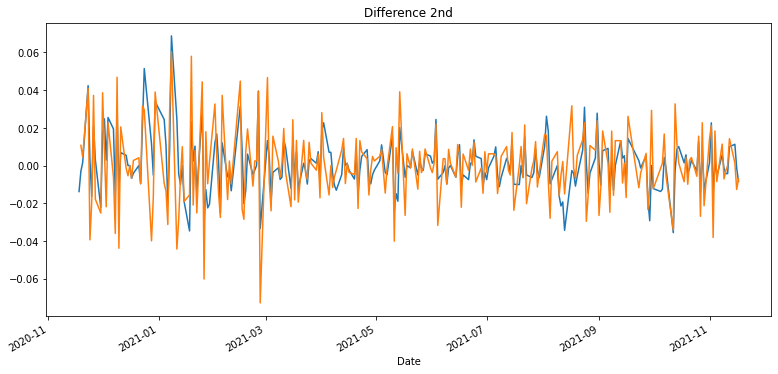

In [41]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d = 1 일 때 p-value 가 0.000031 로 안정화 상태를 보였으며,

d = 2 일 때, p-value 가 5.478890e-11 로 매우 안정화 상태를 보였습니다.

하지만, d = 1 로 먼저 시도해 보고, d 값을 바꿔가면서 최적의 값을 찾아보도록 하겠습니다.

## STEP 6. ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [42]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA

#### (1) p=1, d=1, q=0

In [43]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  222
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 623.094
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 18 Nov 2021   AIC                          -1240.188
Time:                        14:16:46   BIC                          -1229.980
Sample:                             1   HQIC                         -1236.067
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0002      0.001      0.190      0.849      -0.002       0.002
ar.L1.D.Close     0.0749      0.067      1.119      0.263      -0.056       0.206
                                    Root

ARIMA 모델이 훈련 결과를 시각적으로 확인해 보겠습니다.

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있습니다. np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산합니다.

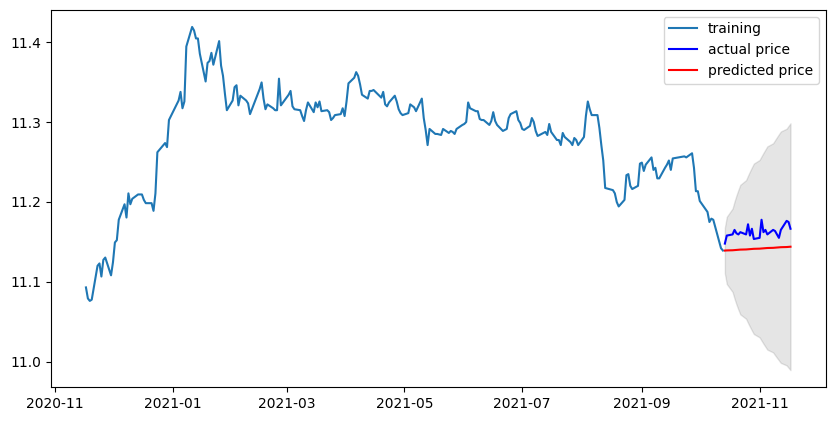

In [44]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [45]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2378778.45286887
MAE:  1472.7906326949567
RMSE:  1542.3289055415094
MAPE: 2.09%


- 예측 모델의 메트릭으로 활용하기에 적당한 MAPE 기준으로 2.09% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (2) p=1, d=2, q=0

In [46]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  221
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 573.097
Method:                       css-mle   S.D. of innovations              0.018
Date:                Thu, 18 Nov 2021   AIC                          -1140.194
Time:                        14:16:55   BIC                          -1130.000
Sample:                             2   HQIC                         -1136.078
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.187e-06      0.001     -0.011      0.991      -0.002       0.002
ar.L1.D2.Close    -0.4237      0.061     -6.927      0.000      -0.544      -0.304
                                    

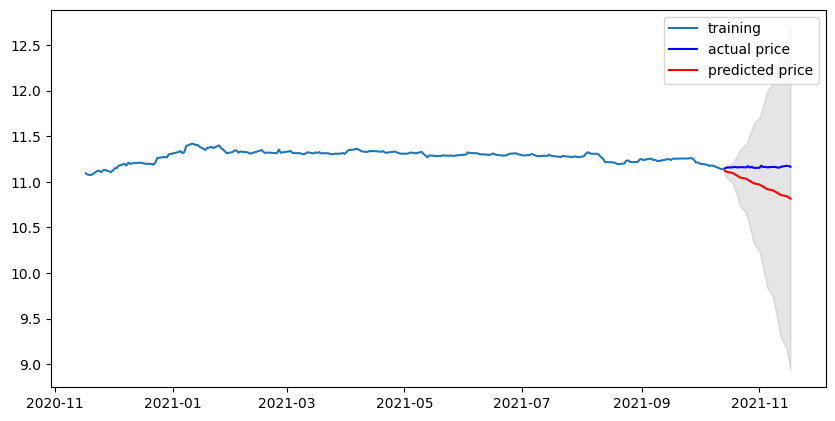

In [47]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [48]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  176391351.53764537
MAE:  12044.326613018486
RMSE:  13281.240587296255
MAPE: 17.07%


- 예측 모델의 메트릭으로 활용하기에 적당하지 않은 MAPE 기준으로 17.07% 정도의 오차율을 보입니다.

#### (3) p=1, d=0, q=0

In [55]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  223
Model:                     ARMA(1, 0)   Log Likelihood                 624.002
Method:                       css-mle   S.D. of innovations              0.015
Date:                Thu, 18 Nov 2021   AIC                          -1242.005
Time:                        14:21:56   BIC                          -1231.783
Sample:                             0   HQIC                         -1237.878
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.2083      0.073    152.745      0.000      11.065      11.352
ar.L1.Close     0.9886      0.010    102.116      0.000       0.970       1.008
                                    Roots       

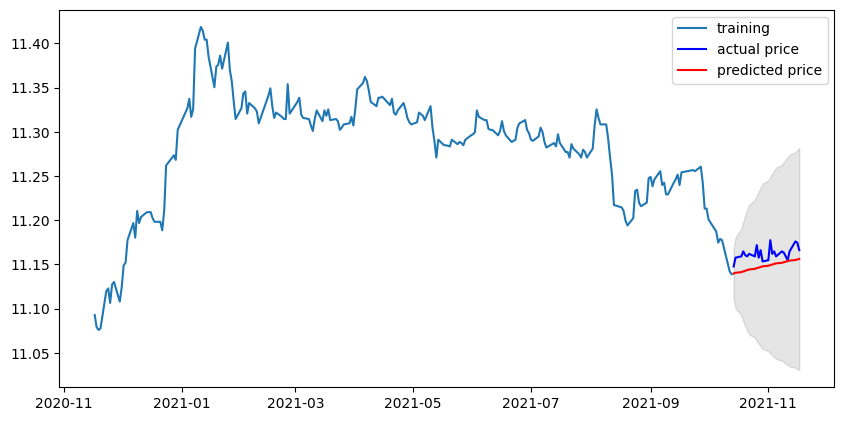

In [56]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [57]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1185695.485094268
MAE:  987.0324425269762
RMSE:  1088.8964528798265
MAPE: 1.40%


- 위와 동일하게 호기심으로 q=0 을 넣어 보았을 뿐인데, MAPE 기준으로 1.40% 정도의 오차율을 보였습니다.

### 정리
- (1) p=1, d=1, q=0 -> MAPE: 2.09%
- (2) p=1, d=2, q=0 -> MAPE: 17.07%
- (3) p=1, d=0, q=0 -> MAPE: 1.40%

### 삼성 ARIMA 모델 최적의 MAPE 결과
- p=1, d=0, q=0 일 때, 1.40%의 정도의 오차율을 보임을 알 수 있었습니다.

## STEP 7. 다른 주식 종목 예측해 보기
---
관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기

- 관심 종목
1. Tesla
2. NVIDIA
3. APPLE

## 7-1. Tesla

## STEP 1. 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/TSLA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-11-16    408.089996
2020-11-17    441.609985
2020-11-18    486.640015
2020-11-19    499.269989
2020-11-20    489.609985
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

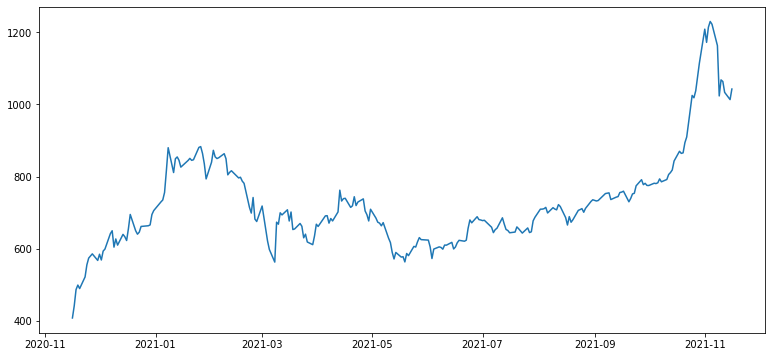

In [59]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [60]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- isna 로 확인 하였으나, 결측치가 없음을 확인했습니다.

Series([], Name: Close, dtype: float64)


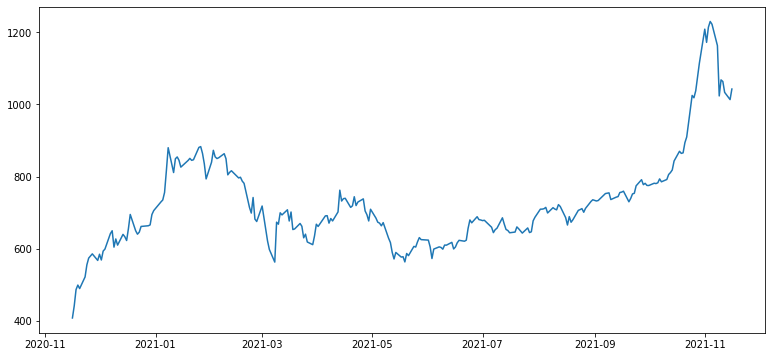

In [61]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

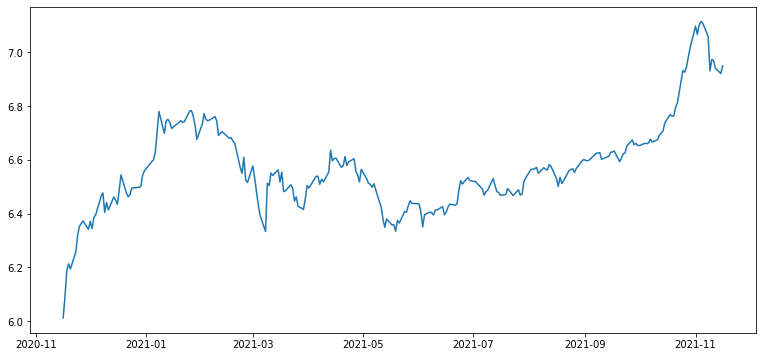

In [62]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

- 위에서 1200에 근접해 있던 차트의 최대값이 로그 변환을 통해 7 정도의 수치로 변환되었음을 확인 할 수 있습니다.

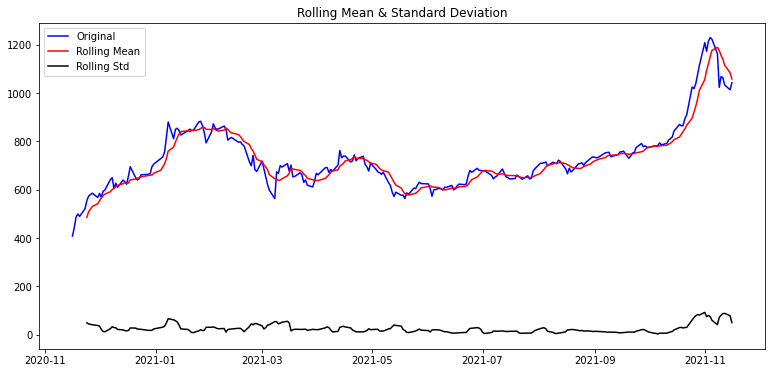

In [63]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# window = 7 (이동평균 = 7, 1주)일 때, 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 7)

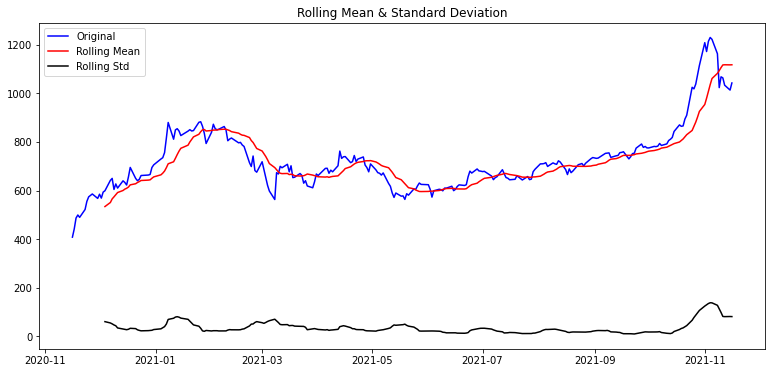

In [64]:
# window = 14 (이동평균 = 14, 2주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 14)

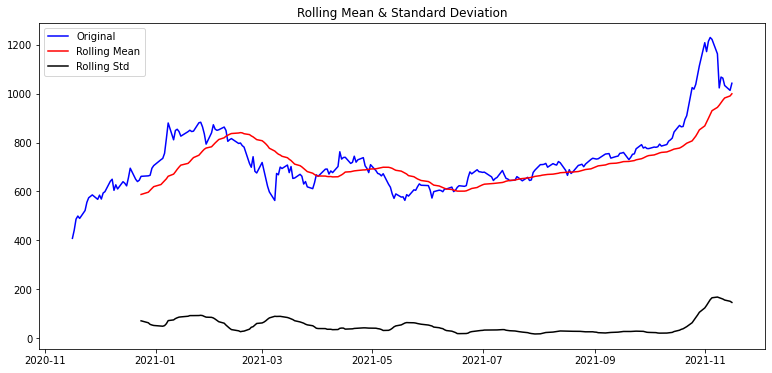

In [65]:
# window = 28 (이동평균 = 28, 4주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 28)

In [66]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                  -1.561162
p-value                          0.503068
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 현재, p-value 값이 0.503068로, p-value를 줄이기 위한 다양한 시도가 필요합니다.

### 2-1. 로그 함수 변환
---

In [67]:
augmented_dickey_fuller_test(ts_log) # 로그 변화 후

Results of Dickey-Fuller Test:
Test Statistic                  -2.540268
p-value                          0.105981
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 우선 로그 변환을 함으로서, p-value 가 약 0.4 정도 감소한 0.105 가 되었음을 확인 할 수 있었습니다.

- 하지만, 아직은 귀무가설을 기각할 수 있을 정도는 아닌 것을 확인 할 수 있습니다.

### 2-2. Moving average 제거 - 추세(Trend) 상쇄하기
---

- 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다.

- 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주도록 하겠습니다.

#### (1) window=7 일 때, Moving average 제거

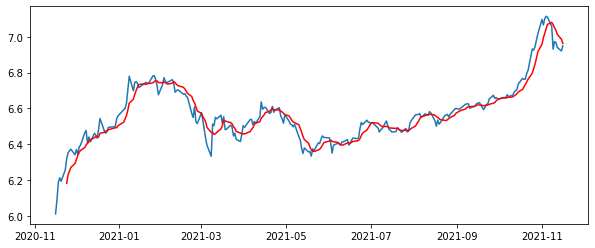

In [68]:
# 기존 그래프와 moving_avg7 시각화
moving_avg7 = ts_log.rolling(window=7).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg7, color='red')

In [69]:
# 변화량, 결측치 제거 후, ts_log_moving_avg7 데이터 확인
ts_log_moving_avg7 = ts_log - moving_avg7 # 변화량 제거
ts_log_moving_avg7.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg7.head(10)

Date
2020-11-24    0.137763
2020-11-25    0.122005
2020-11-27    0.101931
2020-11-30    0.048453
2020-12-01    0.055659
2020-12-02    0.006599
2020-12-03    0.030519
2020-12-04    0.029202
2020-12-07    0.082147
2020-12-08    0.079881
Name: Close, dtype: float64

이전 스텝에서 정의했던 메소드들을 활용하여 ts_log_moving_avg를 정성, 정량적으로 분석을 진행합니다.

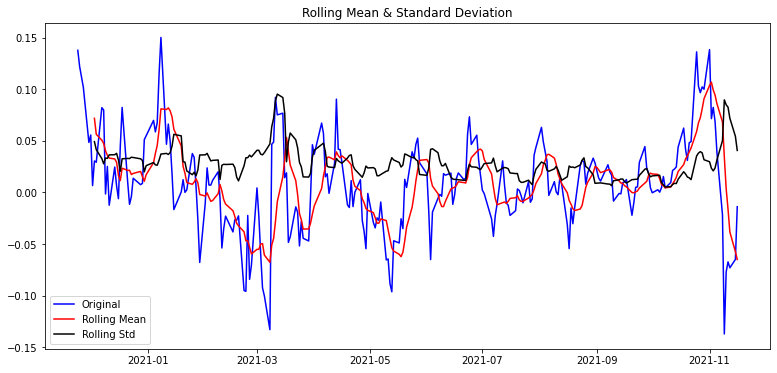

In [70]:
# log 변환 후, log_moving_avg7 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg7)

In [71]:
# log_moving_avg7 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg7)

Results of Dickey-Fuller Test:
Test Statistic                -6.055201e+00
p-value                        1.249975e-07
#Lags Used                     0.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


- p-value 값이 1.249975e-07이므로, 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있습니다.

#### (2) window=14 일 때, Moving average 제거

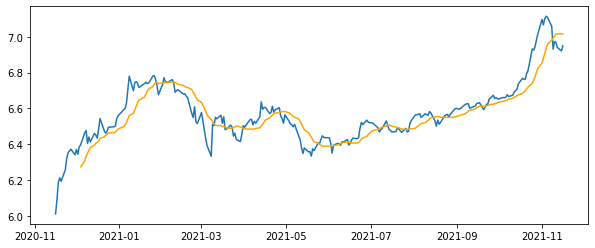

In [72]:
# 기존 그래프와 moving_avg14 시각화
moving_avg14= ts_log.rolling(window=14).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg14, color='orange')

In [73]:
# 변화량, 결측치 제거 후, ts_log_moving_avg14 데이터 확인
ts_log_moving_avg14 = ts_log - moving_avg14 # 변화량 제거
ts_log_moving_avg14.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg14.head(10)

Date
2020-12-04    0.121320
2020-12-07    0.157869
2020-12-08    0.142845
2020-12-09    0.054937
2020-12-10    0.075347
2020-12-11    0.032029
2020-12-14    0.065230
2020-12-15    0.045521
2020-12-16    0.023008
2020-12-17    0.066760
Name: Close, dtype: float64

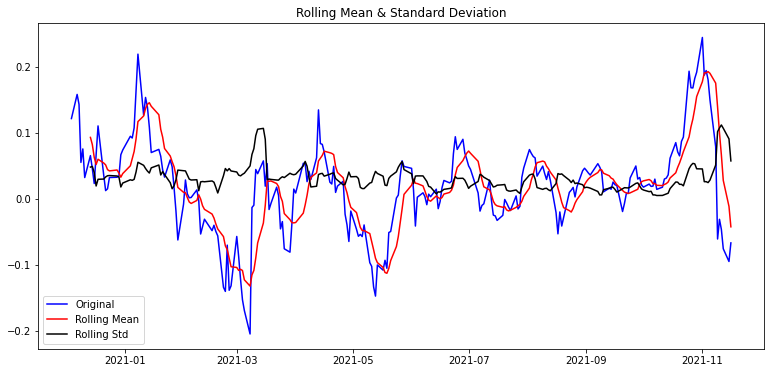

In [74]:
# log 변환 후, log_moving_avg14 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg14)

In [75]:
# log_moving_avg14 의 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg14)

Results of Dickey-Fuller Test:
Test Statistic                  -3.762389
p-value                          0.003316
#Lags Used                       0.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


- log_moving_avg14 의 p-value 가 0.003316 로 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있습니다.

- 하지만, log_moving_avg7 의 p-value 이 더 낮으므로, log_moving_avg7로 진행하도록 하겠습니다.

#### (3) window=28 일 때, Moving average 제거
---

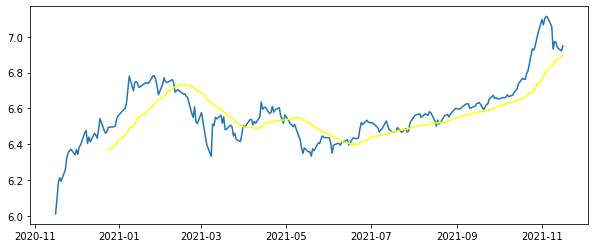

In [76]:
# 기존 그래프와 moving_avg28 시각화
moving_avg28 = ts_log.rolling(window=28).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg28, color='yellow')

In [77]:
# 변화량, 결측치 제거 후, ts_log_moving_avg28 데이터 확인
ts_log_moving_avg28 = ts_log - moving_avg28 # 변화량 제거
ts_log_moving_avg28.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg28.head(10)

Date
2020-12-24    0.126468
2020-12-28    0.111997
2020-12-29    0.100783
2020-12-30    0.130387
2020-12-31    0.133582
2021-01-04    0.152909
2021-01-05    0.147963
2021-01-06    0.164945
2021-01-07    0.228828
2021-01-08    0.289772
Name: Close, dtype: float64

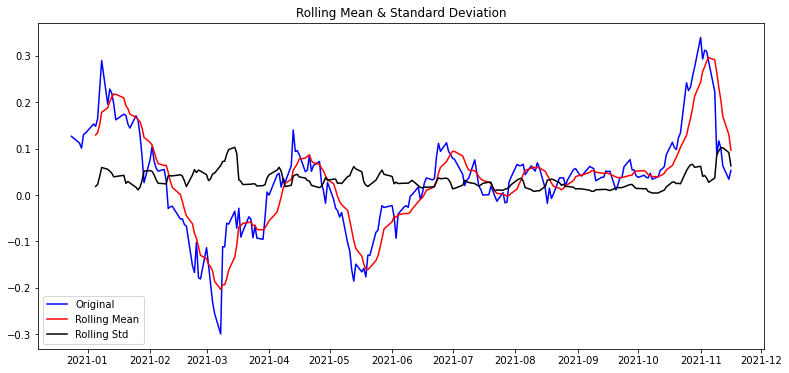

In [78]:
# log 변환 후, log_moving_avg14 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg28)

In [79]:
# log_moving_avg28 의 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg28)

Results of Dickey-Fuller Test:
Test Statistic                  -2.468038
p-value                          0.123446
#Lags Used                       0.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


- log_moving_avg7 의 p-value 이 log_moving_avg28 의 p-value더 낮으므로, log_moving_avg7로 진행하도록 하겠습니다.

### 2-3 차분(Differencing) - 계절성(Seasonality) 상쇄하기
---
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.

- 이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있습니다. 마치 미분(Differentiation)을 떠올리게 하는 개념인데요, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법입니다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됩니다. 이 변화량 시계열은 어떤 패턴을 보이게 될 지 확인해 봅시다.

- 우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보겠습니다.

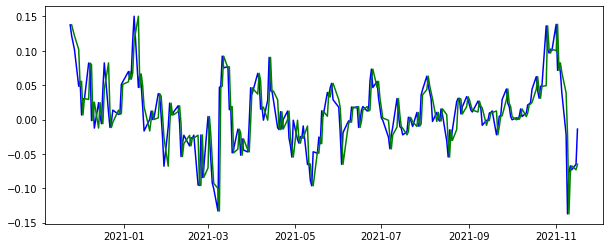

In [80]:
# log_moving_avg7 과 log_moving_avg7를 시프트한 시계열 그래프 시각화
ts_log_moving_avg_shift = ts_log_moving_avg7.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg7, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현해 봅시다.

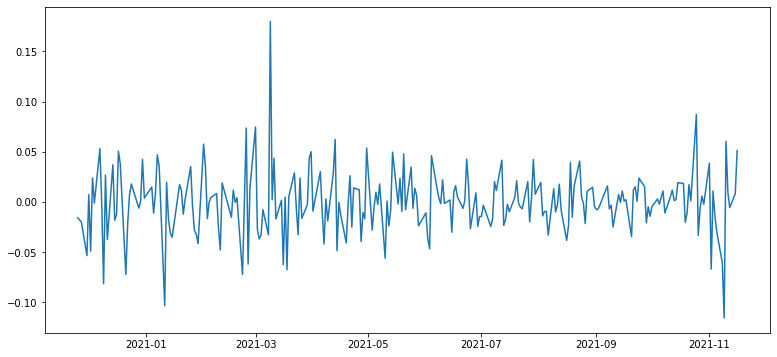

In [81]:
ts_log_moving_avg_diff = ts_log_moving_avg7 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

## STEP 3. 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 3-1. 정성적 그래프 분석

- 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악

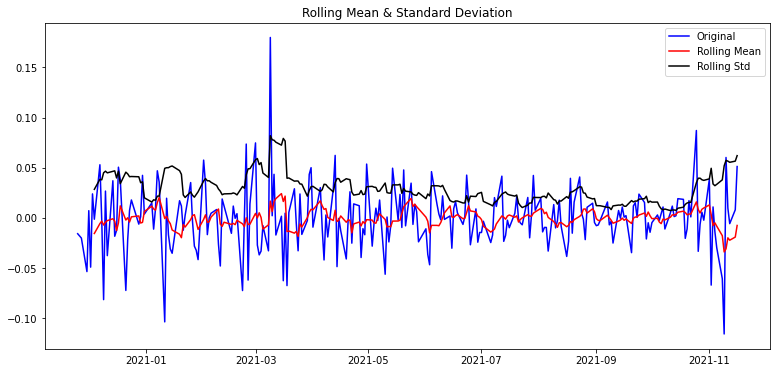

In [82]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

### 3-2. 정량적 Augmented Dicky-Fuller Test
- 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행

In [83]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -6.855816e+00
p-value                        1.649586e-09
#Lags Used                     1.000000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가

1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과,

p-value가 1.649586e-09 로 매우 작은 값으로 줄었음을 확인 할 수 있습니다.

### 3-3. 시계열 분해(Time Series Decomposition)

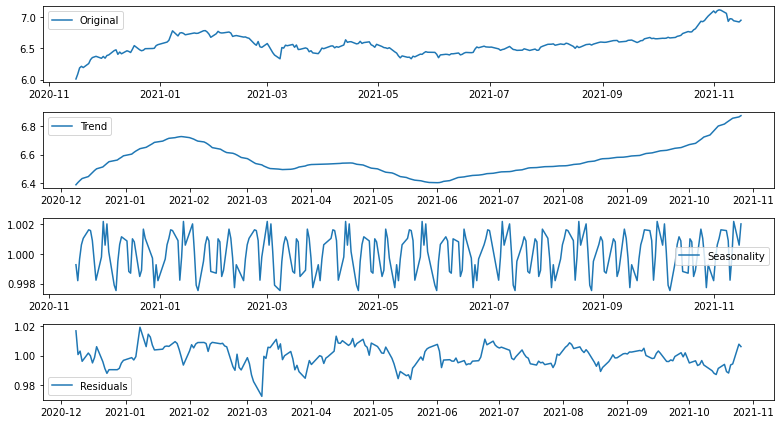

In [84]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.

뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다.

이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

### 3-4. Residual 안정성 확인

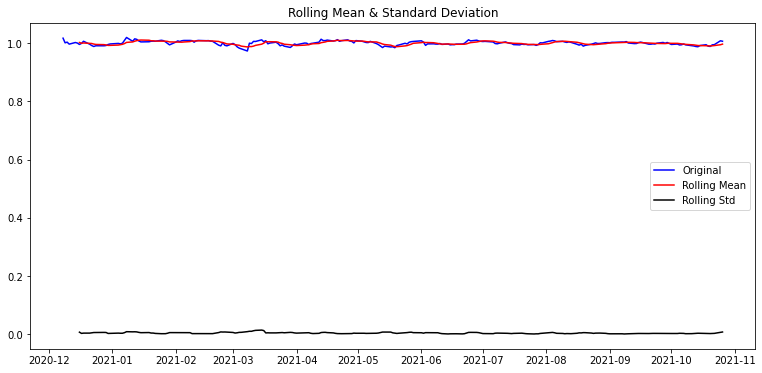

In [85]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [86]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.568042
p-value                          0.000001
#Lags Used                       9.000000
Number of Observations Used    213.000000
Critical Value (1%)             -3.461429
Critical Value (5%)             -2.875207
Critical Value (10%)            -2.574054
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다.

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까 싶긴 하겠다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 할 수 있겠습니다.

## STEP 4. 학습, 테스트 데이터셋 생성
---
- 학습, 테스트 데이터셋을 9 : 1 비율로 분리

In [87]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [88]:
print(len(train_data))
print(len(test_data))

227
26


- 학습 데이터와 테스트 데이터가 227, 26개로 분리 되었음을 확인 할 수 있습니다.

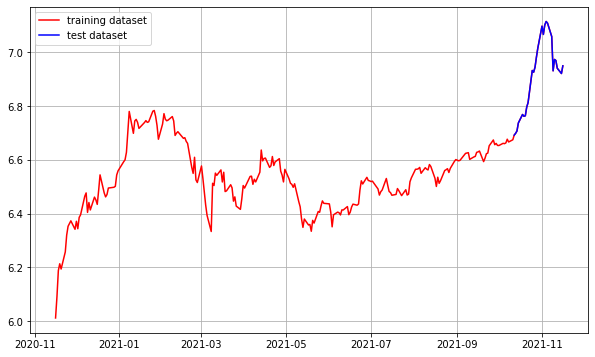

In [89]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

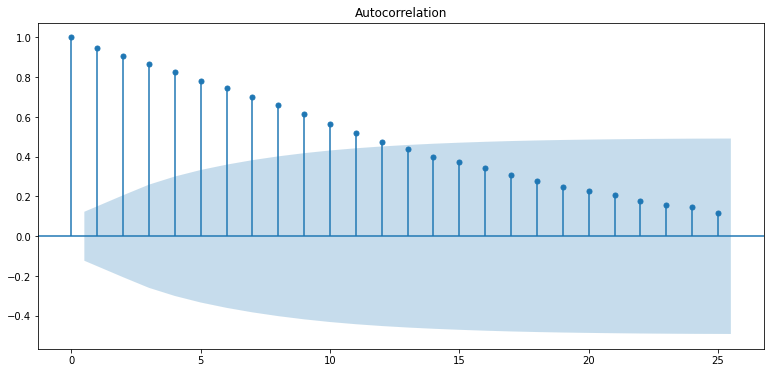

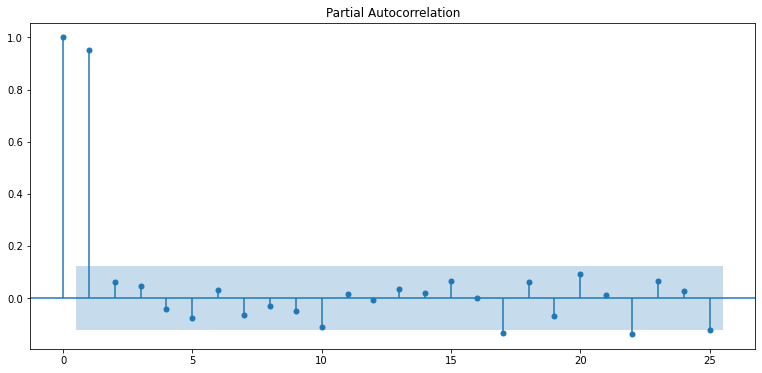

In [90]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위의 그래프의 결론을 내려보자면,

- ACF 그래프를 보면,1에서 25로 갈수록 1에서 0.2로 수렴함을 확인 할 수 있으므로, 적합한 q(MA 모델의 시차) 값이 없을 것 같습니다. 우선 q = 0 으로 진행해 보겠습니다.

- PACF 그래프를 보면 p (AR 모델의 시차) = 1 이 매우 적합할 것으로 보입니다. P가 2 이상인 구간에서 PACF는 거의 0에 가까워 지고 있기 때문입니다. (PACF가 0 이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.)

Results of Dickey-Fuller Test:
Test Statistic                -1.648906e+01
p-value                        2.201018e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


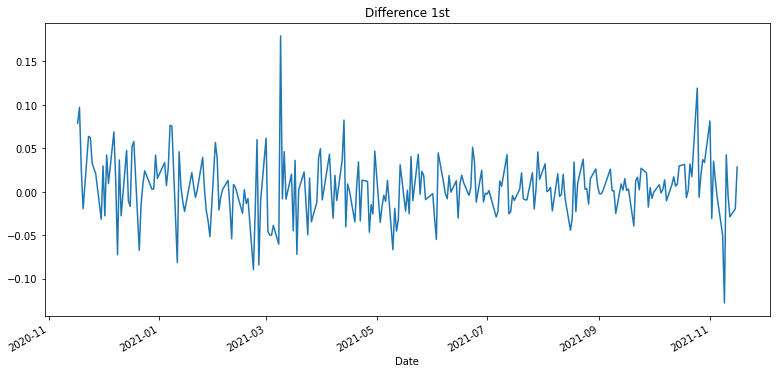

In [91]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

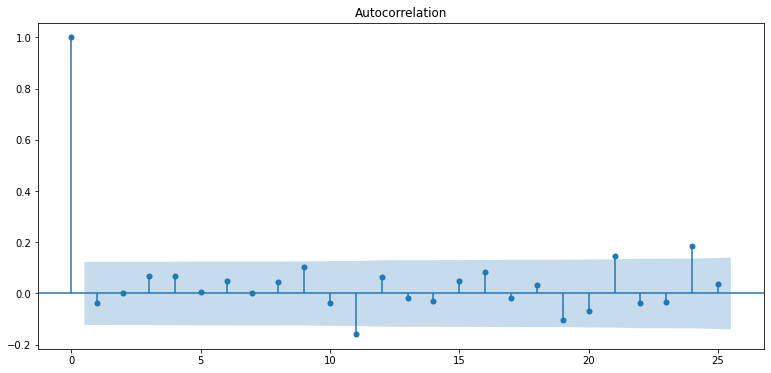

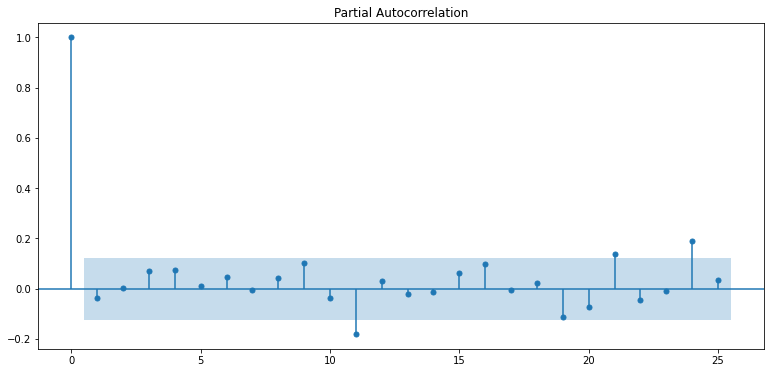

In [92]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -7.112879e+00
p-value                        3.897762e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


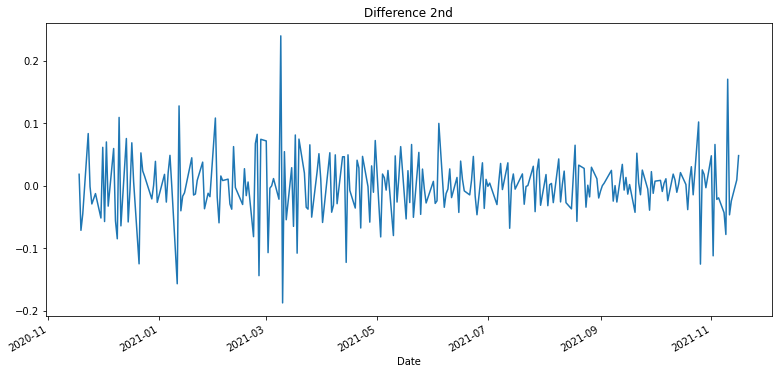

In [93]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

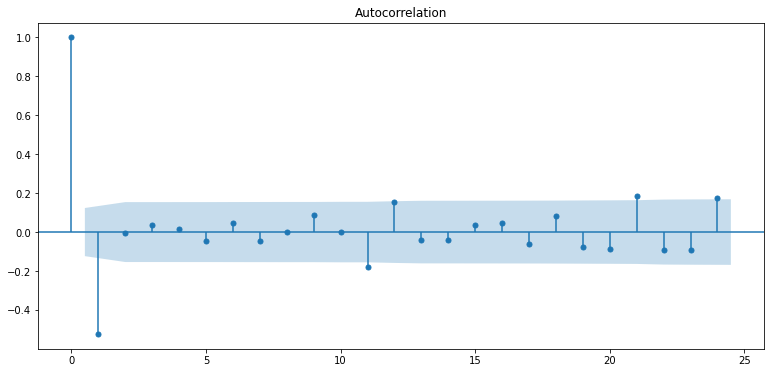

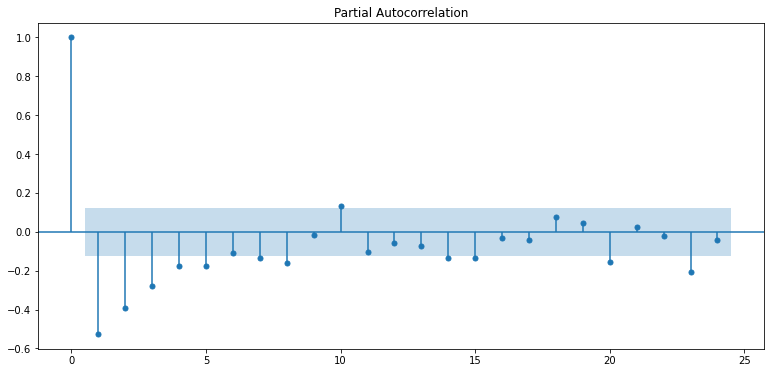

In [94]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.648906e+01
p-value                        2.201018e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.112879e+00
p-value                        3.897762e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


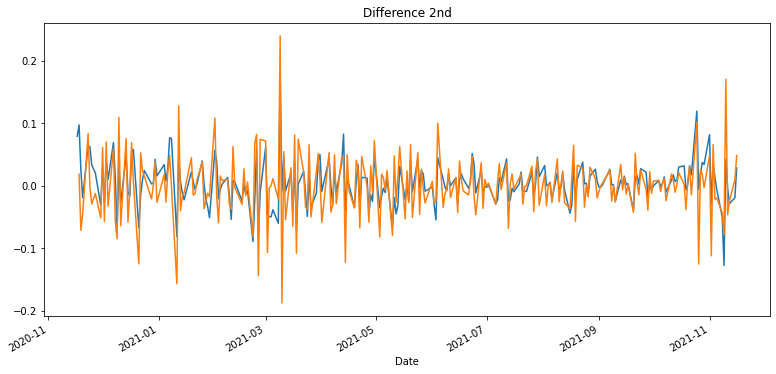

In [95]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d = 1 일 때나 d = 2 일 때, 모두  p-value 가 각각 2.201018e-29, 3.897762e-10 와 로 매우 안정화 상태를 보였습니다.

하지만, d = 0 부터 먼저 시도해 보고, d 값을 바꿔가면서 최적의 값을 찾아보도록 하겠습니다.

## STEP 6. ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [96]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA

#### (1) p=1, d=0, q=0

In [97]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  227
Model:                     ARMA(1, 0)   Log Likelihood                 444.232
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 18 Nov 2021   AIC                           -882.464
Time:                        14:46:07   BIC                           -872.189
Sample:                             0   HQIC                          -878.318
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           6.4514      0.151     42.808      0.000       6.156       6.747
ar.L1.Close     0.9881      0.012     81.893      0.000       0.964       1.012
                                    Roots       

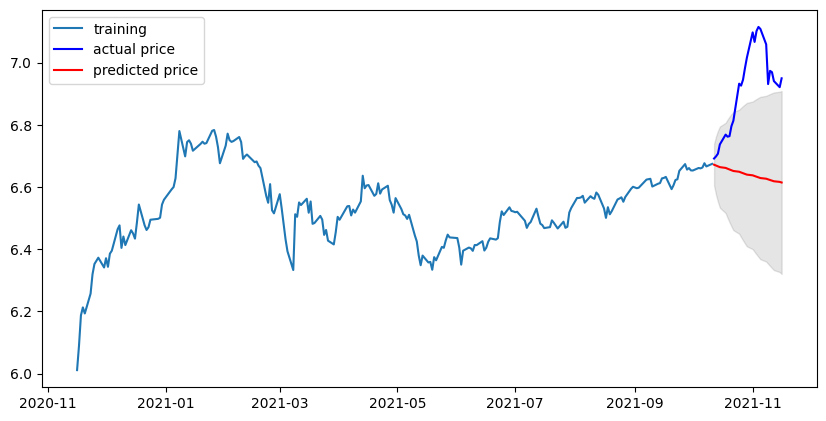

In [98]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [99]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  83270.5314821517
MAE:  249.07504401921764
RMSE:  288.56633809602897
MAPE: 22.98%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 22.98% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (2) p=1, d=1, q=0

In [100]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 445.096
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 18 Nov 2021   AIC                           -884.192
Time:                        14:47:41   BIC                           -873.930
Sample:                             1   HQIC                          -880.051
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.002      1.375      0.169      -0.001       0.007
ar.L1.D.Close    -0.0606      0.067     -0.904      0.366      -0.192       0.071
                                    Root

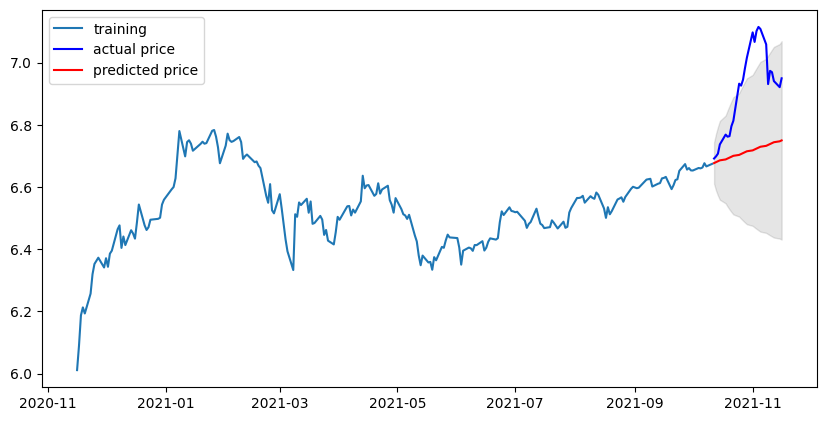

In [101]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [102]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  52126.06631412106
MAE:  192.04023243329155
RMSE:  228.31133636795406
MAPE: 17.60%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 17.60% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (3) p=1, d=2, q=0

In [109]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 395.329
Method:                       css-mle   S.D. of innovations              0.042
Date:                Thu, 18 Nov 2021   AIC                           -784.658
Time:                        15:00:32   BIC                           -774.410
Sample:                             2   HQIC                          -780.522
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0004      0.002     -0.203      0.839      -0.004       0.003
ar.L1.D2.Close    -0.5247      0.056     -9.288      0.000      -0.635      -0.414
                                    

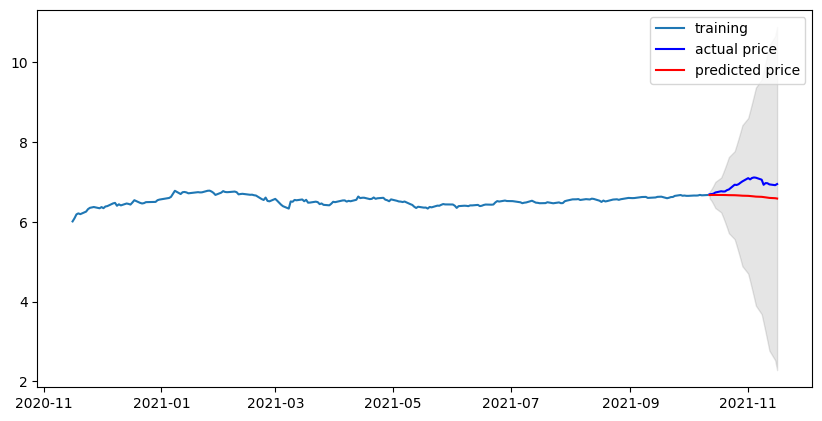

In [110]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [111]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  81291.99109755753
MAE:  243.91982545275394
RMSE:  285.11750401818114
MAPE: 22.45%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 22.45% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (4) p=0, d=1, q=0

In [115]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 444.688
Method:                           css   S.D. of innovations              0.034
Date:                Thu, 18 Nov 2021   AIC                           -885.376
Time:                        15:06:23   BIC                           -878.535
Sample:                             1   HQIC                          -882.615
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0029      0.002      1.304      0.192      -0.001       0.007


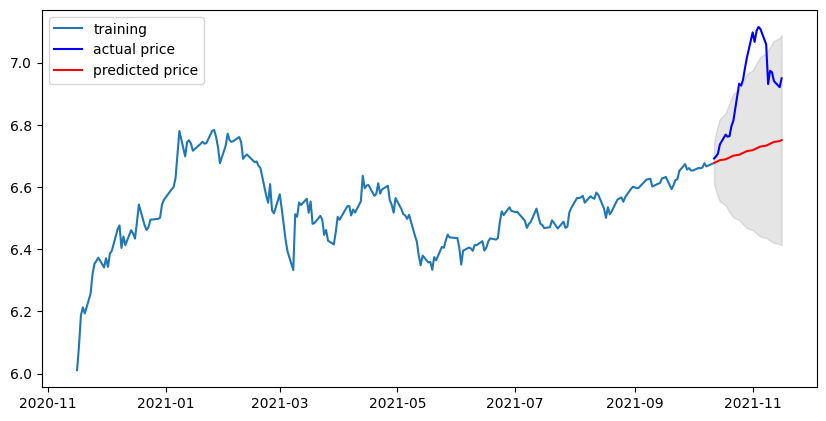

In [116]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [117]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  51920.80317801638
MAE:  191.56060459820006
RMSE:  227.86136833174768
MAPE: 17.55%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 17.55% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (5) p=0, d=1, q=1

In [118]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 445.114
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 18 Nov 2021   AIC                           -884.228
Time:                        15:06:31   BIC                           -873.966
Sample:                             1   HQIC                          -880.087
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0029      0.002      1.382      0.167      -0.001       0.007
ma.L1.D.Close    -0.0631      0.068     -0.928      0.354      -0.196       0.070
                                    Root

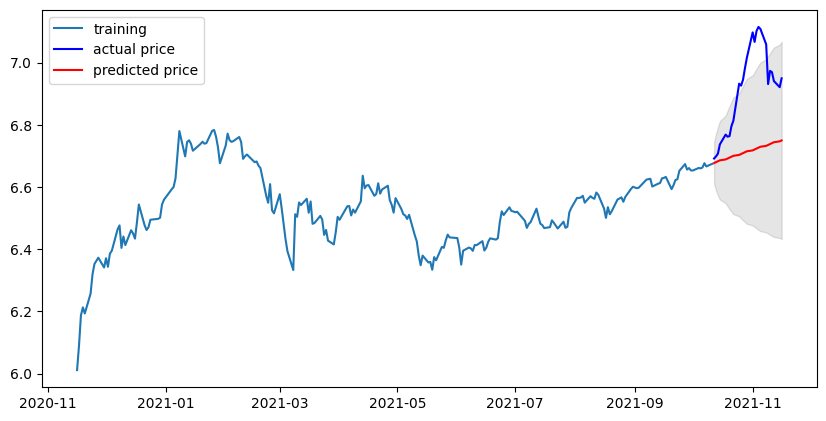

In [119]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [120]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  52139.60186458392
MAE:  192.06564288736746
RMSE:  228.34097719109445
MAPE: 17.60%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 17.60% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (6) p=0, d=2, q=0

In [121]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 358.945
Method:                           css   S.D. of innovations              0.049
Date:                Thu, 18 Nov 2021   AIC                           -713.890
Time:                        15:33:14   BIC                           -707.058
Sample:                             2   HQIC                          -711.133
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.003     -0.096      0.923      -0.007       0.006


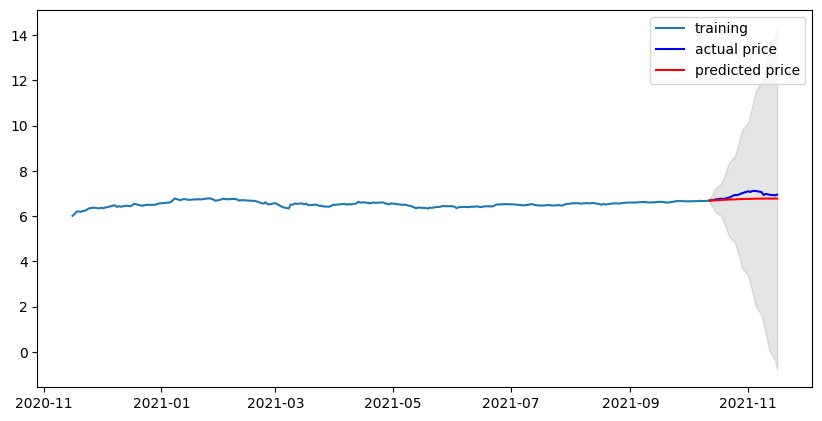

In [122]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [123]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40757.31226860975
MAE:  165.30749660652862
RMSE:  201.88440323266616
MAPE: 15.02%


- 드디어... 예측 모델의 메트릭으로 활용하기에 유의미한 MAPE 기준으로 15.02% 정도의 오차율을 찾았습니다!!

#### (7) p=0, d=2, q=1

In [124]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 2, 1))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 440.936
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 18 Nov 2021   AIC                           -875.872
Time:                        15:34:08   BIC                           -865.623
Sample:                             2   HQIC                          -871.735
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.661e-05   9.59e-05     -0.799      0.424      -0.000       0.000
ma.L1.D2.Close    -0.9646      0.023    -41.842      0.000      -1.010      -0.919
                                    

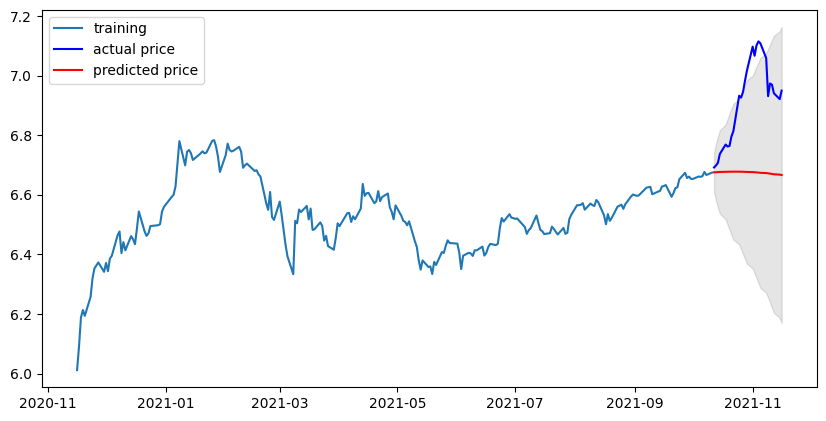

In [125]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [126]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  68627.24385657201
MAE:  223.66502167810117
RMSE:  261.96802067537175
MAPE: 20.57%


- 아쉽게도, 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 20.57% 정도의 오차율을 보여주었습니다.

### 정리

#### (1) p=1, d=0, q=0 -> MAPE: 22.98%

#### (2) p=1, d=1, q=0 -> MAPE: 17.60%

#### (3) p=1, d=2, q=0 -> MAPE: 22.45%

#### (4) p=0, d=1, q=0 -> MAPE: 17.55%

#### (5) p=0, d=1, q=1 -> MAPE: 17.60%

#### (6) p=0, d=2, q=0 -> MAPE: 15.02%

#### (7) p=0, d=2, q=1 -> MAPE: 20.57%

### 7-1. Tesla ARIMA 모델 최적의 MAPE 결과
-  p=0, d=2, q=0 일 때, 15.02%의 정도의 오차율을 보임을 알 수 있었습니다.

## 7-2. NVIDIA

## STEP 1. 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-11-16    135.152496
2020-11-17    134.222504
2020-11-18    134.287506
2020-11-19    134.402496
2020-11-20    130.877502
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

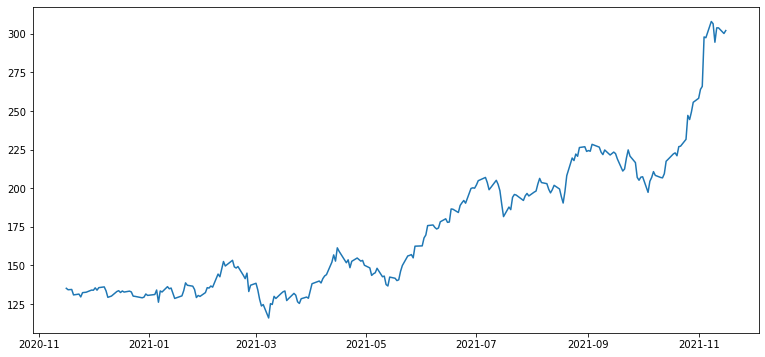

In [129]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [130]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- isna 로 확인 하였으나, 결측치가 없음을 확인했습니다.

Series([], Name: Close, dtype: float64)


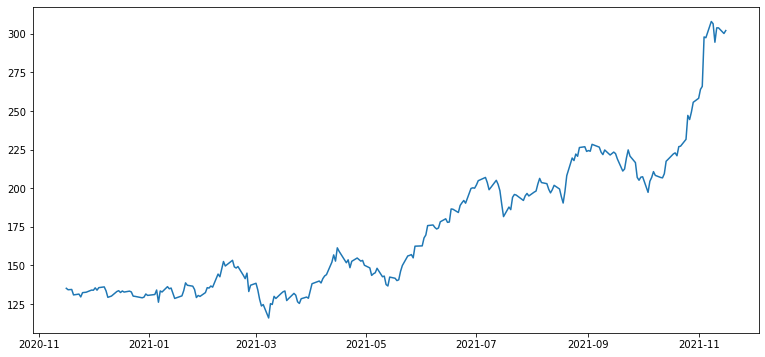

In [131]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

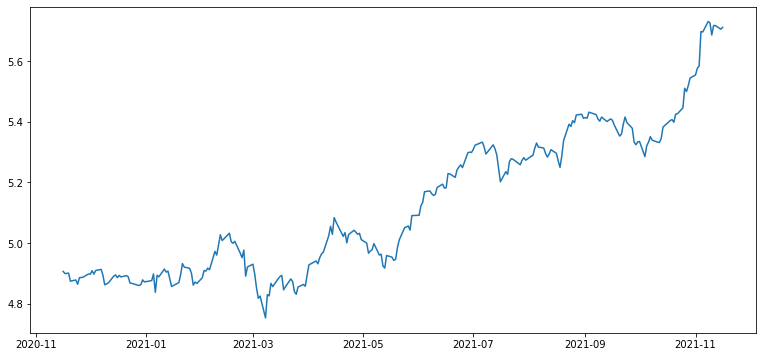

In [132]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

- 위에서 300에 근접해 있던 차트의 최대값이 로그 변환을 통해 5.8 이하의 수치로 변환되었음을 확인 할 수 있습니다.

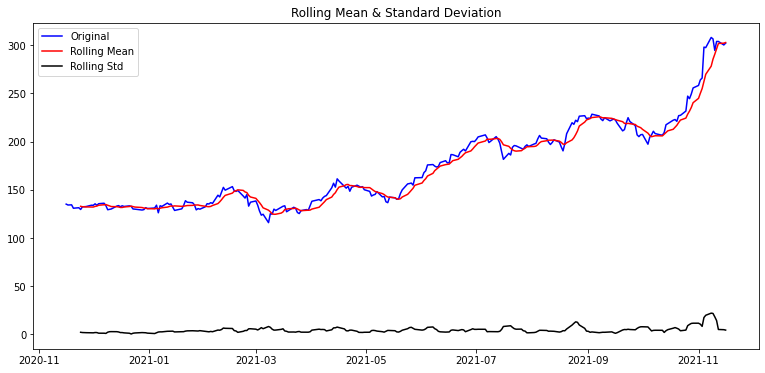

In [133]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# window = 7 (이동평균 = 7, 1주)일 때, 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 7)

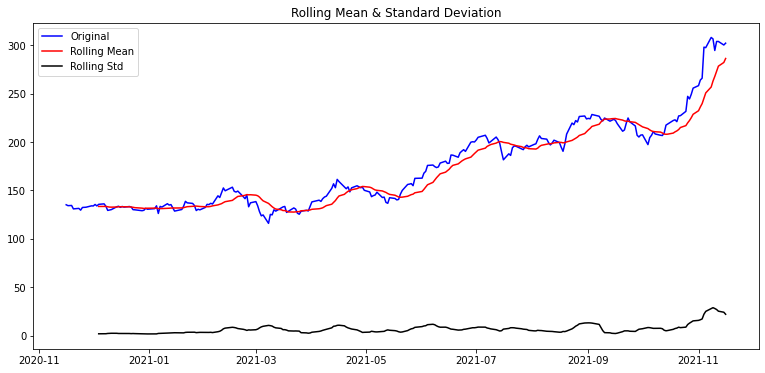

In [134]:
# window = 14 (이동평균 = 14, 2주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 14)

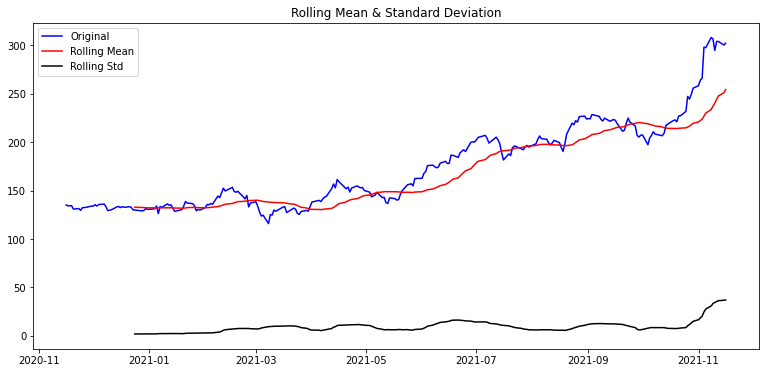

In [135]:
# window = 28 (이동평균 = 28, 4주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 28)

In [136]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                   1.589891
p-value                          0.997827
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 현재, p-value 값이 0.997827로, p-value를 줄이기 위한 다양한 시도가 필요합니다.

### 2-1. 로그 함수 변환
---

In [137]:
augmented_dickey_fuller_test(ts_log) # 로그 변화 후

Results of Dickey-Fuller Test:
Test Statistic                   0.734155
p-value                          0.990495
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 우선 로그 변환을 함으로서, p-value 가 약 0.007 정도 감소한 0.990495 가 되었음을 확인 할 수 있었습니다.

- 하지만, 아직은 귀무가설을 기각할 수 있을 정도는 아닌 것을 확인 할 수 있습니다.

### 2-2. Moving average 제거 - 추세(Trend) 상쇄하기
---

- 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다.

- 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주도록 하겠습니다.

#### (1) window=7 일 때, Moving average 제거

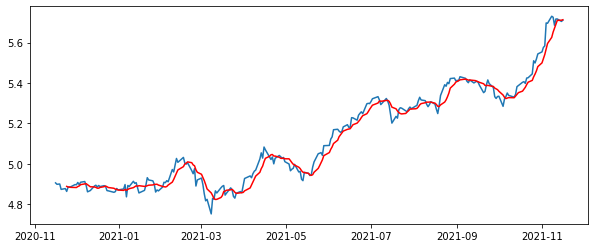

In [138]:
# 기존 그래프와 moving_avg7 시각화
moving_avg7 = ts_log.rolling(window=7).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg7, color='red')

In [139]:
# 변화량, 결측치 제거 후, ts_log_moving_avg7 데이터 확인
ts_log_moving_avg7 = ts_log - moving_avg7 # 변화량 제거
ts_log_moving_avg7.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg7.head(10)

Date
2020-11-24   -0.024794
2020-11-25   -0.000646
2020-11-27    0.003078
2020-11-30    0.013889
2020-12-01    0.013565
2020-12-02    0.020137
2020-12-03    0.006357
2020-12-04    0.011924
2020-12-07    0.011535
2020-12-08   -0.008468
Name: Close, dtype: float64

이전 스텝에서 정의했던 메소드들을 활용하여 ts_log_moving_avg를 정성, 정량적으로 분석을 진행합니다.

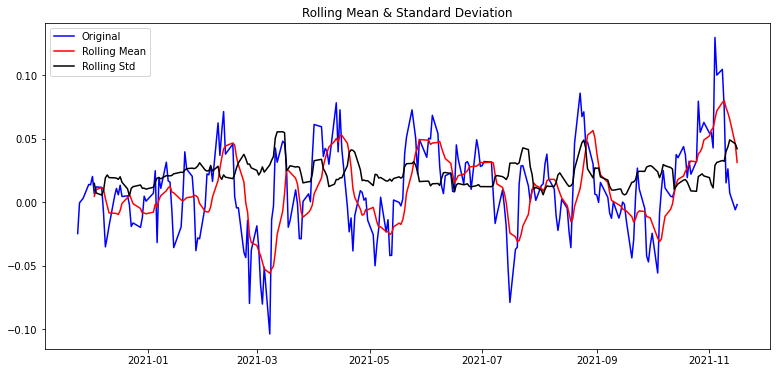

In [140]:
# log 변환 후, log_moving_avg7 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg7)

In [141]:
# log_moving_avg7 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg7)

Results of Dickey-Fuller Test:
Test Statistic                  -5.555882
p-value                          0.000002
#Lags Used                       0.000000
Number of Observations Used    246.000000
Critical Value (1%)             -3.457215
Critical Value (5%)             -2.873362
Critical Value (10%)            -2.573070
dtype: float64


- p-value 값이 0.000002 이므로, 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있습니다.

#### (2) window=14 일 때, Moving average 제거

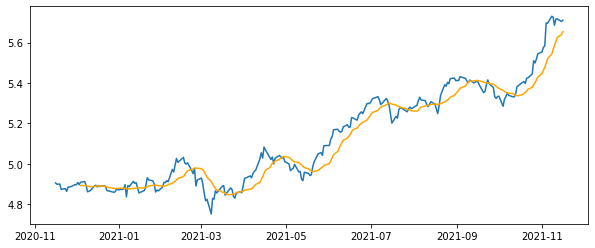

In [142]:
# 기존 그래프와 moving_avg14 시각화
moving_avg14= ts_log.rolling(window=14).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg14, color='orange')

In [143]:
# 변화량, 결측치 제거 후, ts_log_moving_avg14 데이터 확인
ts_log_moving_avg14 = ts_log - moving_avg14 # 변화량 제거
ts_log_moving_avg14.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg14.head(10)

Date
2020-12-04    0.016216
2020-12-07    0.019304
2020-12-08    0.000640
2020-12-09   -0.028569
2020-12-10   -0.022833
2020-12-11   -0.019269
2020-12-14    0.002273
2020-12-15    0.003967
2020-12-16   -0.004946
2020-12-17    0.002054
Name: Close, dtype: float64

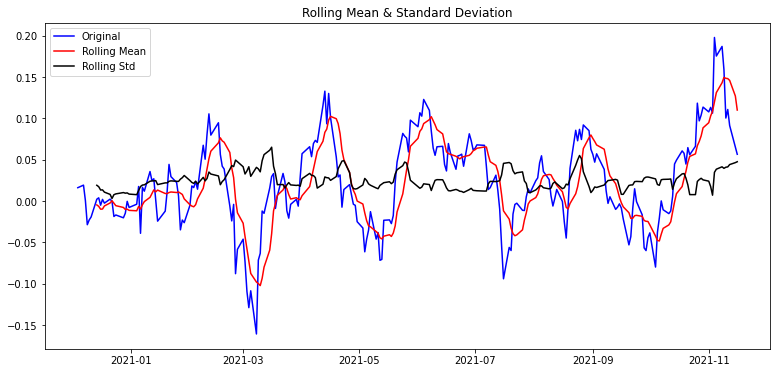

In [144]:
# log 변환 후, log_moving_avg14 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg14)

In [145]:
# log_moving_avg14 의 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg14)

Results of Dickey-Fuller Test:
Test Statistic                  -3.429864
p-value                          0.009982
#Lags Used                       0.000000
Number of Observations Used    239.000000
Critical Value (1%)             -3.458011
Critical Value (5%)             -2.873710
Critical Value (10%)            -2.573256
dtype: float64


- log_moving_avg14 의 p-value 가 0.009982 로 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있습니다.

- 하지만, log_moving_avg7 의 p-value 이 더 낮으므로, log_moving_avg7로 진행하도록 하겠습니다.

-> samsung, tesla를 하면서 쌓은 경험으로, 앞으론 1주 (window = 7) 값으로 p-value를 구하고, 95% 이상의 confidence로 이 time series는 stationary한 여부를 체크해보도록 하겠습니다.

### 2-3 차분(Differencing) - 계절성(Seasonality) 상쇄하기
---
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.

- 이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있습니다. 마치 미분(Differentiation)을 떠올리게 하는 개념인데요, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법입니다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됩니다. 이 변화량 시계열은 어떤 패턴을 보이게 될 지 확인해 봅시다.

- 우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보겠습니다.

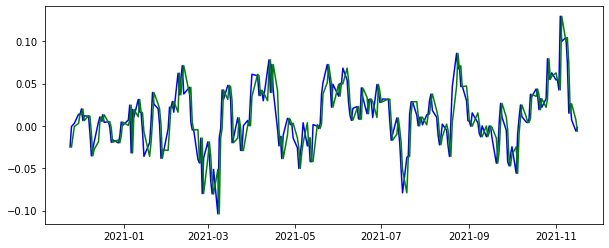

In [146]:
# log_moving_avg7 과 log_moving_avg7를 시프트한 시계열 그래프 시각화
ts_log_moving_avg_shift = ts_log_moving_avg7.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg7, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현해 봅시다.

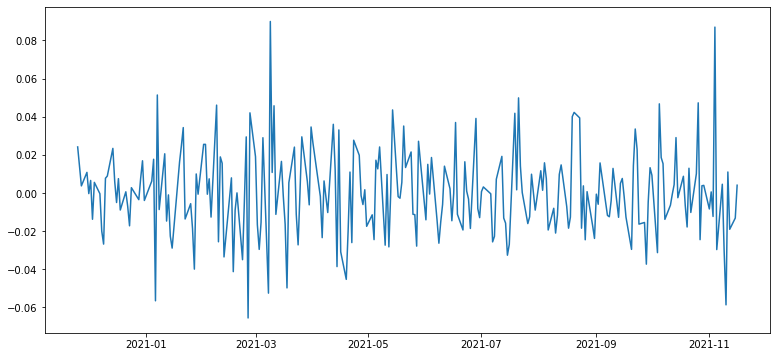

In [147]:
ts_log_moving_avg_diff = ts_log_moving_avg7 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

## STEP 3. 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 3-1. 정성적 그래프 분석

- 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악

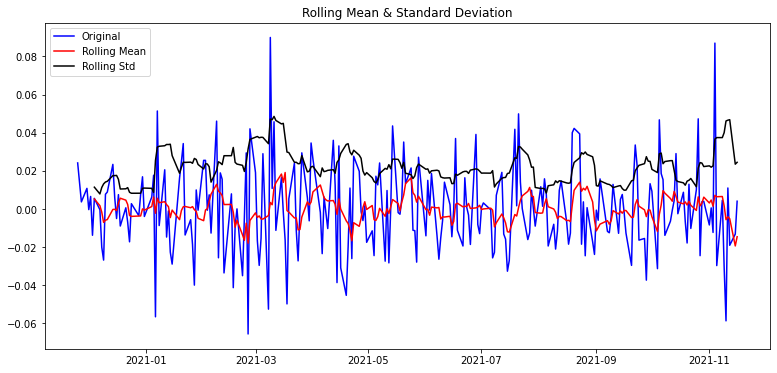

In [148]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

### 3-2. 정량적 Augmented Dicky-Fuller Test
- 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행

In [149]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                -8.763736e+00
p-value                        2.631585e-14
#Lags Used                     5.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가

1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과,

p-value가 2.631585e-14 로 매우 작은 값으로 줄었음을 확인 할 수 있습니다.

### 3-3. 시계열 분해(Time Series Decomposition)

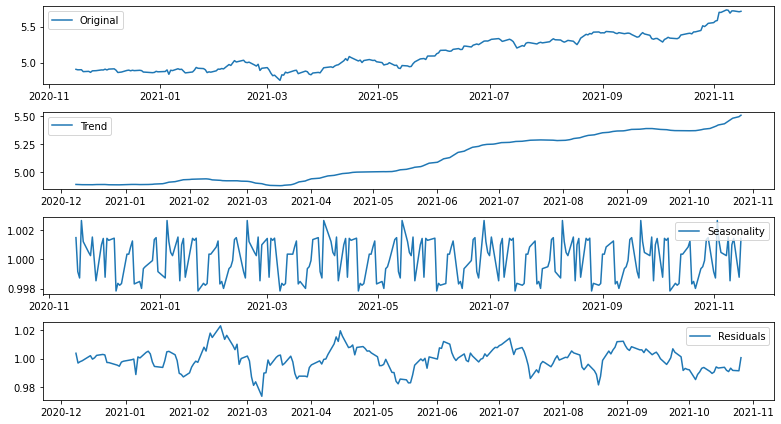

In [150]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.

뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다.

이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

### 3-4. Residual 안정성 확인

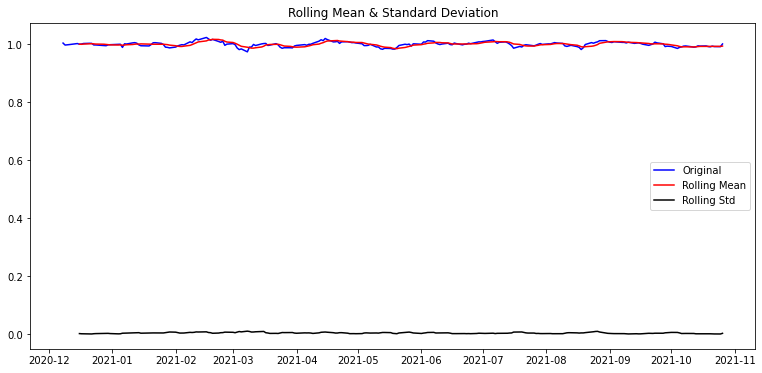

In [151]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [152]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -4.647659
p-value                          0.000105
#Lags Used                       2.000000
Number of Observations Used    220.000000
Critical Value (1%)             -3.460428
Critical Value (5%)             -2.874769
Critical Value (10%)            -2.573821
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줍니다.

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까 싶긴 하겠다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 할 수 있겠습니다.

## STEP 4. 학습, 테스트 데이터셋 생성
---
- 학습, 테스트 데이터셋을 9 : 1 비율로 분리

In [153]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [154]:
print(len(train_data))
print(len(test_data))

227
26


- 학습 데이터와 테스트 데이터가 227, 26개로 분리 되었음을 확인 할 수 있습니다.

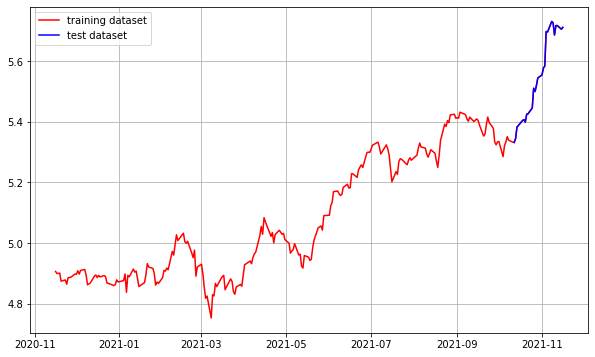

In [155]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

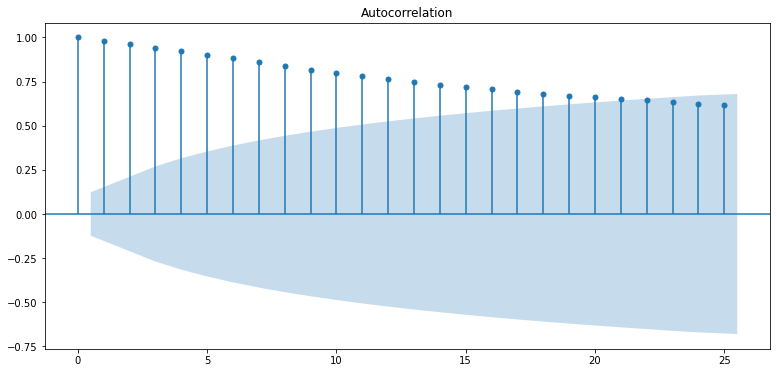

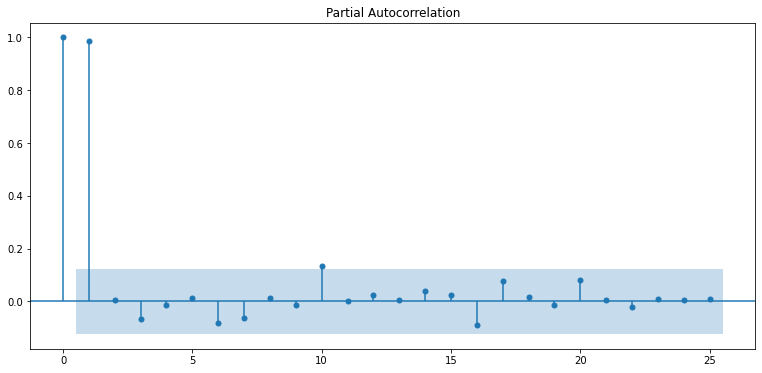

In [156]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위의 그래프의 결론을 내려보자면,

- ACF 그래프를 보면,1에서 25로 갈수록 1에서 0.6 무렵으로 수렴함을 확인 할 수 있으므로, 적합한 q(MA 모델의 시차) 값이 없을 것 같습니다. 우선 q = 0 으로 진행해 보겠습니다.

- PACF 그래프를 보면 p (AR 모델의 시차) = 1 이 매우 적합할 것으로 보입니다. P가 2 이상인 구간에서 PACF는 거의 0에 가까워 지고 있기 때문입니다. (PACF가 0 이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.)

Results of Dickey-Fuller Test:
Test Statistic                -1.661594e+01
p-value                        1.714632e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


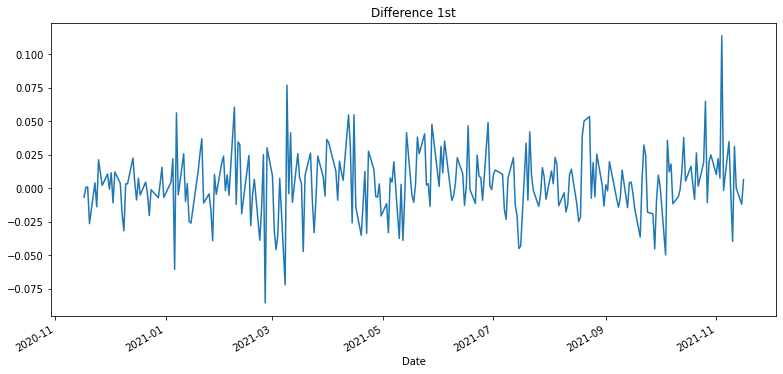

In [157]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

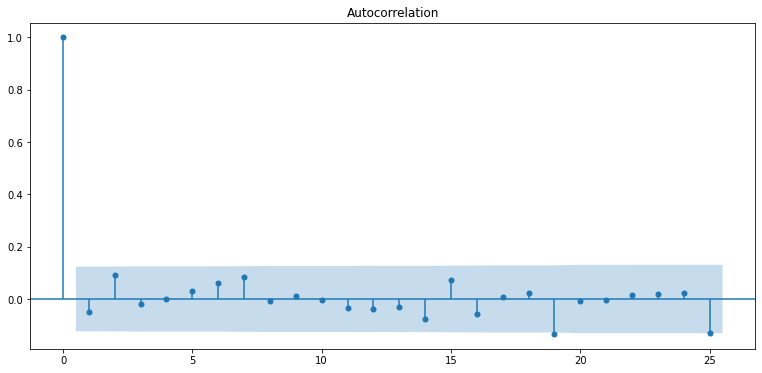

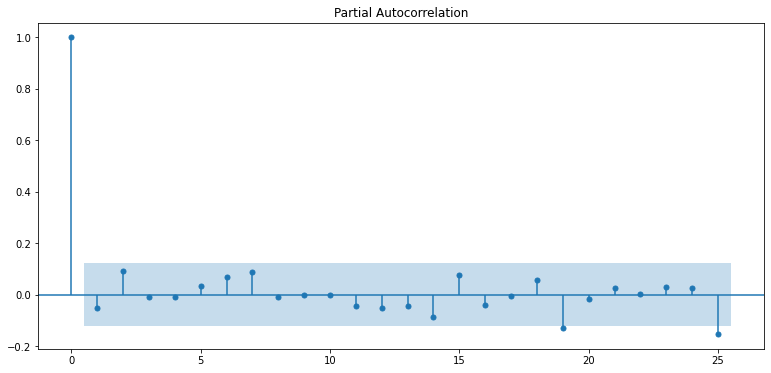

In [158]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.185447e+01
p-value                        7.081317e-22
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


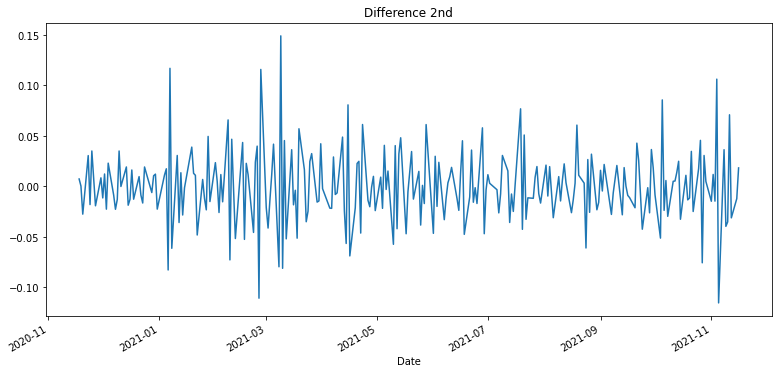

In [159]:
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

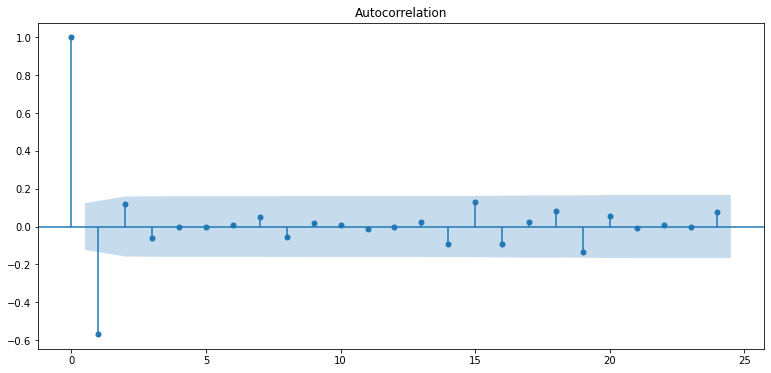

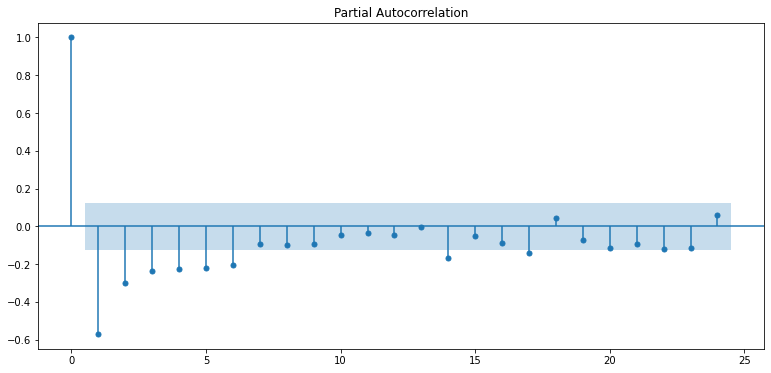

In [160]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.661594e+01
p-value                        1.714632e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.185447e+01
p-value                        7.081317e-22
#Lags Used                     5.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


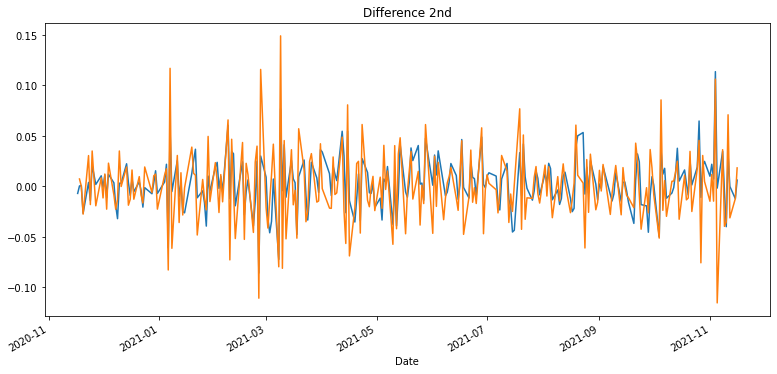

In [161]:
# 차분 안정성 확인 -> d 구하기
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d = 1 일 때나 d = 2 일 때, 모두  p-value 가 각각 1.714632e-29, 7.081317e-22 와 로 매우 안정화 상태를 보였습니다.

하지만, d = 0 부터 먼저 시도해 보고, d 값을 바꿔가면서 최적의 값을 찾아보도록 하겠습니다.

## STEP 6. ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [162]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA

#### (1) p=1, d=0, q=0

In [163]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  227
Model:                     ARMA(1, 0)   Log Likelihood                 521.920
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1037.840
Time:                        16:03:38   BIC                          -1027.565
Sample:                             0   HQIC                         -1033.693
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.1024      0.154     33.119      0.000       4.800       5.404
ar.L1.Close     0.9931      0.006    159.870      0.000       0.981       1.005
                                    Roots       

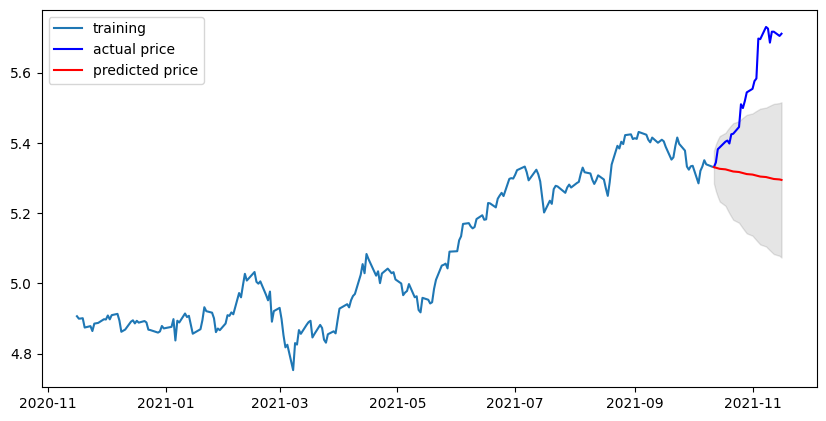

In [164]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [165]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4432.007794860763
MAE:  55.029057445814445
RMSE:  66.57332645182125
MAPE: 19.74%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 19.74% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (2) p=1, d=1, q=0

In [166]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 522.462
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1038.924
Time:                        16:04:36   BIC                          -1028.663
Sample:                             1   HQIC                         -1034.783
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.002      1.253      0.210      -0.001       0.005
ar.L1.D.Close    -0.0579      0.066     -0.874      0.382      -0.188       0.072
                                    Root

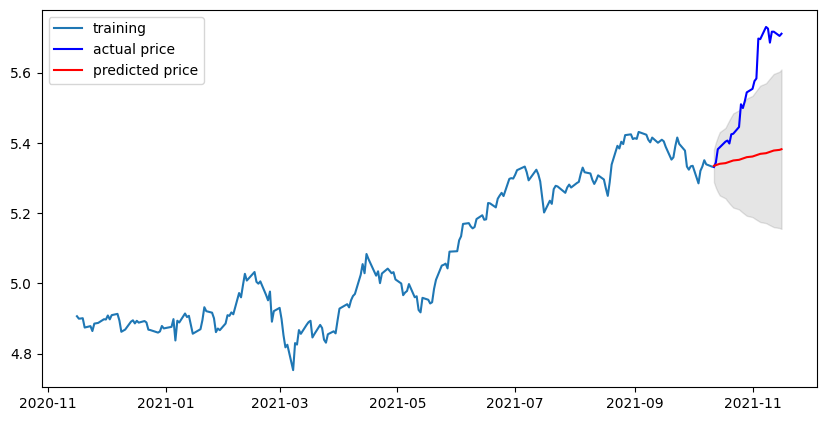

In [167]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [168]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3116.298568991674
MAE:  45.49036401500981
RMSE:  55.823817219818224
MAPE: 16.25%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 16.25% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (3) p=1, d=2, q=0

In [169]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 477.084
Method:                       css-mle   S.D. of innovations              0.029
Date:                Thu, 18 Nov 2021   AIC                           -948.168
Time:                        16:06:29   BIC                           -937.920
Sample:                             2   HQIC                          -944.032
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -1.834e-05      0.001     -0.015      0.988      -0.002       0.002
ar.L1.D2.Close    -0.5573      0.055    -10.128      0.000      -0.665      -0.449
                                    

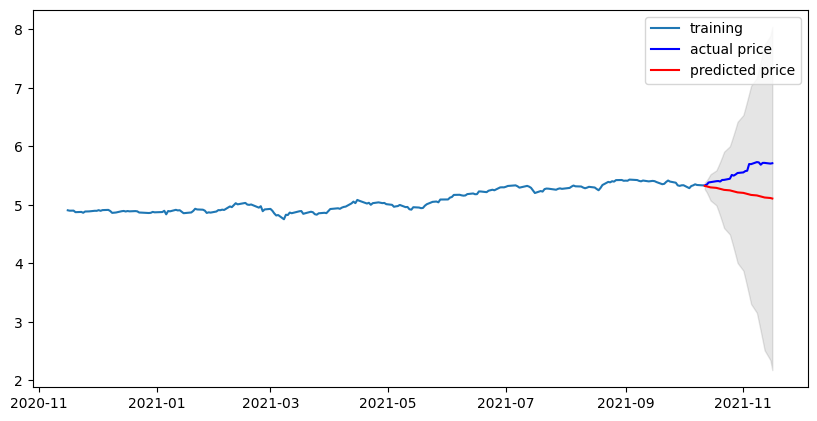

In [170]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [171]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  7564.360083528891
MAE:  73.19954390713428
RMSE:  86.97332972543302
MAPE: 26.41%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 26.41% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (4) p=0, d=1, q=0

In [172]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 522.081
Method:                           css   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1040.162
Time:                        16:07:51   BIC                          -1033.320
Sample:                             1   HQIC                         -1037.401
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.180      0.238      -0.001       0.005


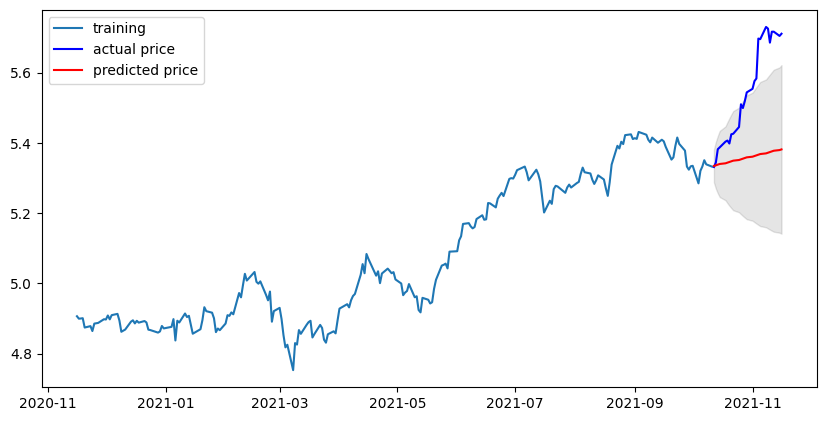

In [173]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [174]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3126.837661194503
MAE:  45.59292504303391
RMSE:  55.918133563223506
MAPE: 16.29%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 16.29% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (5) p=0, d=1, q=1

In [175]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  226
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 522.420
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1038.839
Time:                        16:08:39   BIC                          -1028.577
Sample:                             1   HQIC                         -1034.698
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0019      0.002      1.249      0.212      -0.001       0.005
ma.L1.D.Close    -0.0516      0.063     -0.823      0.411      -0.175       0.071
                                    Root

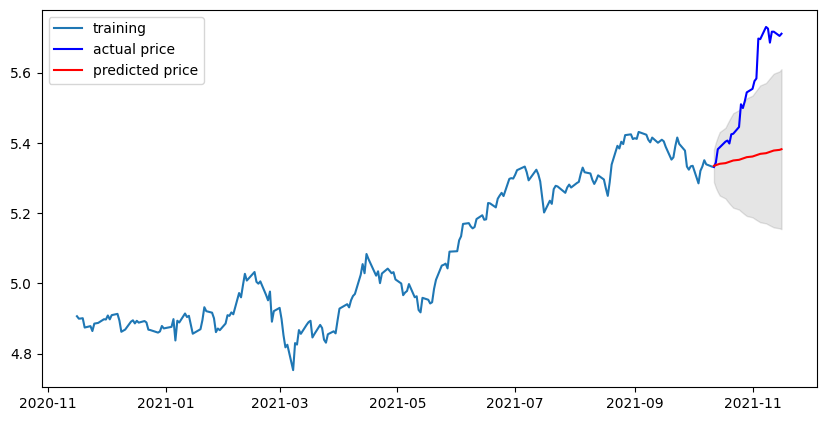

In [176]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [177]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3116.184080492729
MAE:  45.48892924332227
RMSE:  55.82279176548526
MAPE: 16.25%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 16.25% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (6) p=0, d=2, q=0

In [178]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 434.996
Method:                           css   S.D. of innovations              0.035
Date:                Thu, 18 Nov 2021   AIC                           -865.992
Time:                        16:10:58   BIC                           -859.159
Sample:                             2   HQIC                          -863.234
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.576e-06      0.002      0.001      0.999      -0.005       0.005


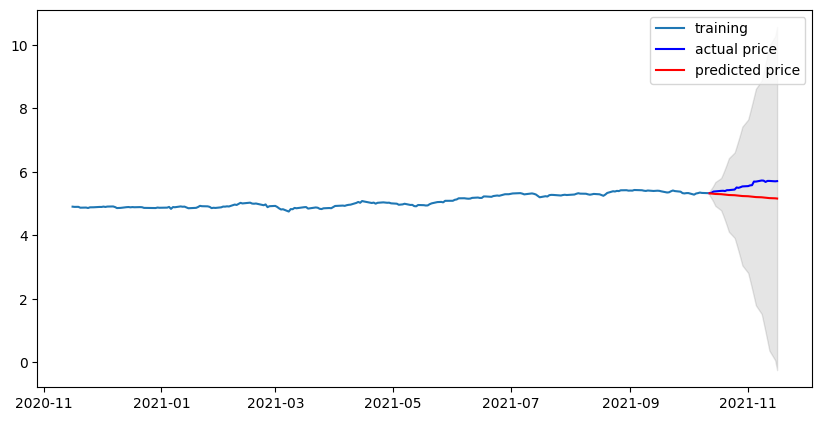

In [179]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [180]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  6612.579106901787
MAE:  68.14975852192916
RMSE:  81.31776624392597
MAPE: 24.56%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 24.56% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (7) p=0, d=2, q=1

In [181]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 2, 1))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  225
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 516.631
Method:                       css-mle   S.D. of innovations              0.024
Date:                Thu, 18 Nov 2021   AIC                          -1027.261
Time:                        16:12:28   BIC                          -1017.013
Sample:                             2   HQIC                         -1023.125
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const           9.112e-06   2.45e-05      0.371      0.710    -3.9e-05    5.72e-05
ma.L1.D2.Close    -1.0000      0.014    -71.320      0.000      -1.027      -0.973
                                    

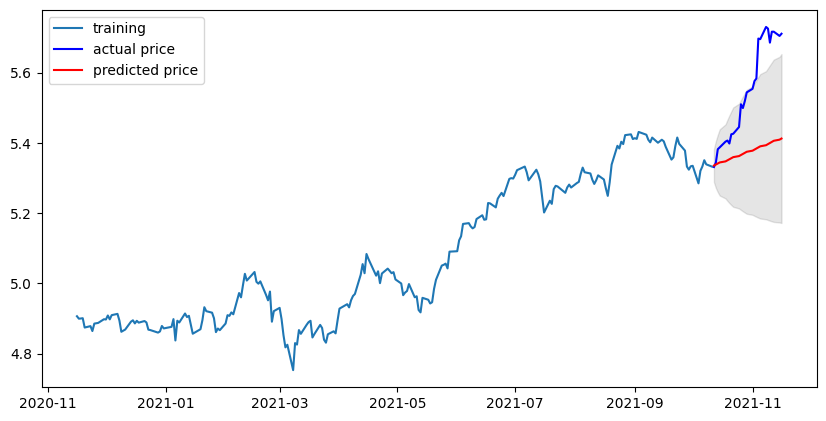

In [182]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [183]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2712.2603949273357
MAE:  42.246331439955576
RMSE:  52.07936630689102
MAPE: 15.07%


- 드디어... 예측 모델의 메트릭으로 활용하기에 유의미한 MAPE 기준으로 15.07% 정도의 오차율을 찾았습니다!!

### 정리

#### (1) p=1, d=0, q=0 -> MAPE: 19.74%

#### (2) p=1, d=1, q=0 -> MAPE: 16.25%

#### (3) p=1, d=2, q=0 -> MAPE: 26.41%

#### (4) p=0, d=1, q=0 -> MAPE: 16.29%

#### (5) p=0, d=1, q=1 -> MAPE: 16.25%

#### (6) p=0, d=2, q=0 -> MAPE: 24.56%

#### (7) p=0, d=2, q=1 -> MAPE: 15.07%

### 7-2. Nvidia ARIMA 모델 최적의 MAPE 결과
-  p=0, d=2, q=1 일 때, 15.07%의 정도의 오차율을 보임을 알 수 있었습니다.

## 7-3. Apple

## STEP 1. 시계열 데이터 준비
---
- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AAPL.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-11-18    118.029999
2020-11-19    118.639999
2020-11-20    117.339996
2020-11-23    113.849998
2020-11-24    115.169998
Name: Close, dtype: float64

## STEP 2. 각종 전처리 수행
---
- 결측치 처리
- 로그 변환

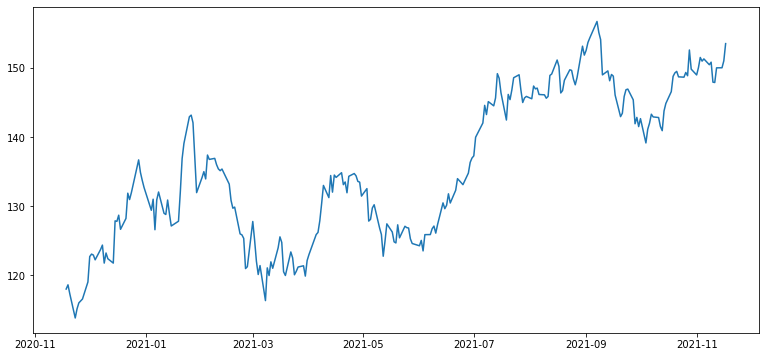

In [185]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

In [186]:
# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

- isna 로 확인 하였으나, 결측치가 없음을 확인했습니다.

Series([], Name: Close, dtype: float64)


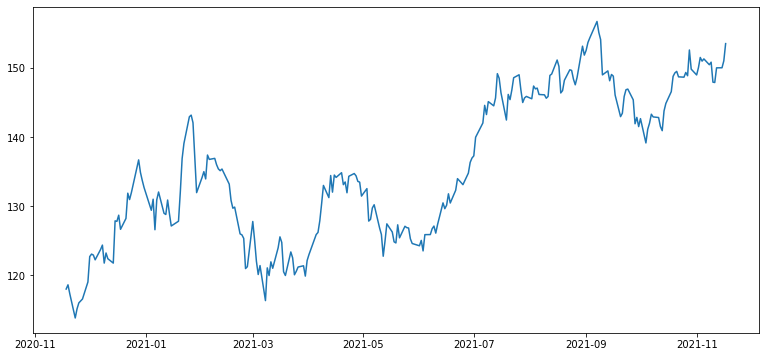

In [187]:
# 결측치가 있다면 이를 보간합니다. 보간 기준은 time을 선택합니다. 
ts=ts.interpolate(method='time')

# 보간 이후 결측치(NaN) 유무를 다시 확인합니다.
print(ts[ts.isna()])

# 다시 그래프를 확인해봅시다!
plt.plot(ts)

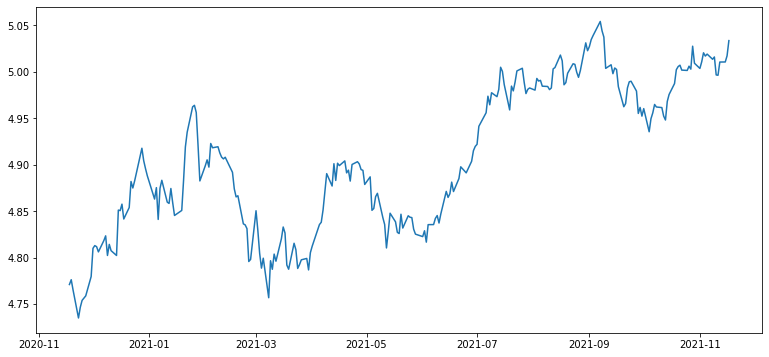

In [188]:
# 로그 변환 시도 
ts_log = np.log(ts)

plt.plot(ts_log)

- 위에서 150 내외에 근접해 있던 차트의 최대값이 로그 변환을 통해 5.05 정도의 수치로 변환되었음을 확인 할 수 있습니다.

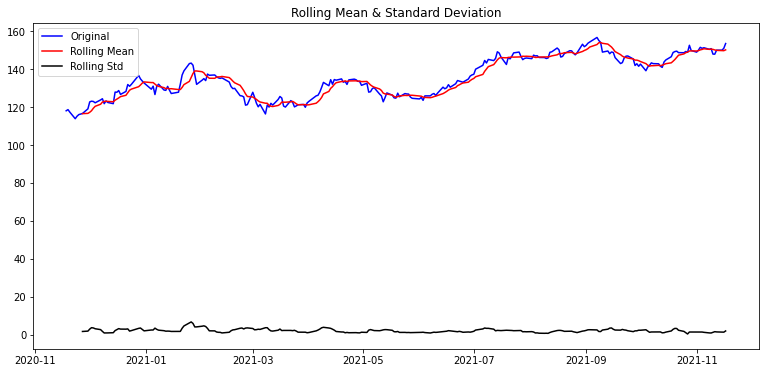

In [189]:
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=7):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

# window = 7 (이동평균 = 7, 1주)일 때, 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 7)

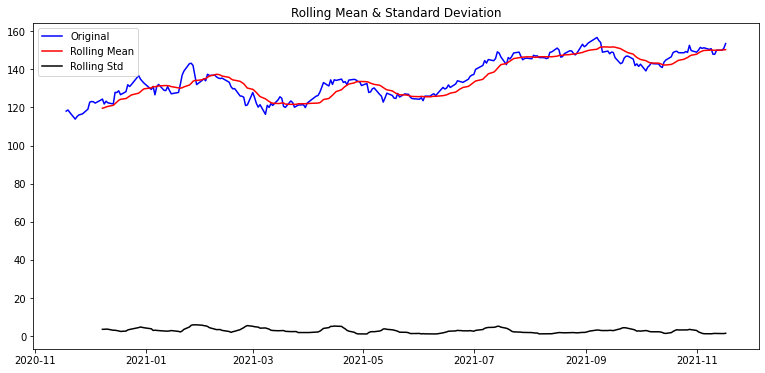

In [190]:
# window = 14 (이동평균 = 14, 2주)로 시각화
fig, ax = plt.subplots(figsize=(13, 6))
plot_rolling_statistics(ts, window = 14)

In [191]:
# 정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
augmented_dickey_fuller_test(ts) # 로그 변환 전

Results of Dickey-Fuller Test:
Test Statistic                  -1.514924
p-value                          0.526116
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


- 현재, p-value 값이 0.526116로, p-value를 줄이기 위한 다양한 시도가 필요합니다.

### 2-1. 로그 함수 변환
---

In [192]:
augmented_dickey_fuller_test(ts_log) # 로그 변화 후

Results of Dickey-Fuller Test:
Test Statistic                  -1.623975
p-value                          0.470646
#Lags Used                       0.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64


- 우선 로그 변환을 함으로서, p-value 가 약 0.4 정도 감소한 0.105 가 되었음을 확인 할 수 있었습니다.

- 하지만, 아직은 귀무가설을 기각할 수 있을 정도는 아닌 것을 확인 할 수 있습니다.

### 2-2. Moving average 제거 - 추세(Trend) 상쇄하기
---

- 시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다.

- 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주도록 하겠습니다.

#### (1) window=7 일 때, Moving average 제거

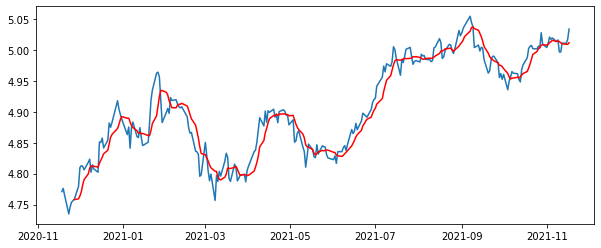

In [193]:
# 기존 그래프와 moving_avg7 시각화
moving_avg7 = ts_log.rolling(window=7).mean()  # moving average구하기 
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log)
plt.plot(moving_avg7, color='red')

In [194]:
# 변화량, 결측치 제거 후, ts_log_moving_avg7 데이터 확인
ts_log_moving_avg7 = ts_log - moving_avg7 # 변화량 제거
ts_log_moving_avg7.dropna(inplace=True) # 결측치 제거
ts_log_moving_avg7.head(10)

Date
2020-11-27    0.000676
2020-11-30    0.020327
2020-12-01    0.045859
2020-12-02    0.041965
2020-12-03    0.029853
2020-12-04    0.015702
2020-12-07    0.018696
2020-12-08    0.014534
2020-12-09   -0.009830
2020-12-10    0.001483
Name: Close, dtype: float64

이전 스텝에서 정의했던 메소드들을 활용하여 ts_log_moving_avg를 정성, 정량적으로 분석을 진행합니다.

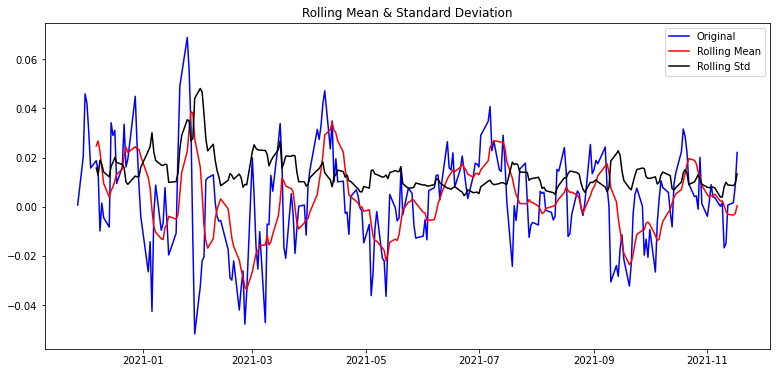

In [196]:
# log 변환 후, log_moving_avg7 정성적 그래프로 시각화
plot_rolling_statistics(ts_log_moving_avg7)

In [197]:
# log_moving_avg7 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log_moving_avg7)

Results of Dickey-Fuller Test:
Test Statistic                -6.121967e+00
p-value                        8.811178e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.450000e+02
Critical Value (1%)           -3.457326e+00
Critical Value (5%)           -2.873410e+00
Critical Value (10%)          -2.573096e+00
dtype: float64


- p-value 값이 8.811178e-08 이므로, 95% 이상의 confidence로 이 time series는 stationary하다고 할 수 있습니다.

### 2-3 차분(Differencing) - 계절성(Seasonality) 상쇄하기
---
- Trend에는 잡히지 않지만 시계열 데이터 안에 포함된 패턴이 파악되지 않은 주기적 변화는 예측에 방해가 되는 불안정성 요소입니다. 이것은 Moving Average 제거로는 상쇄되지 않는 효과입니다. 이런 계절적, 주기적 패턴을 계절성(Seasonality)라고 합니다.

- 이런 패턴을 상쇄하기 위해 효과적인 방법에는 차분(Differencing)이 있습니다. 마치 미분(Differentiation)을 떠올리게 하는 개념인데요, 시계열을 한 스텝 앞으로 시프트한 시계열을 원래 시계열에 빼 주는 방법입니다. 이렇게 되면 남은 것은 현재 스텝 값 - 직전 스텝 값이 되어 정확히 이번 스텝에서 발생한 변화량을 의미하게 됩니다. 이 변화량 시계열은 어떤 패턴을 보이게 될 지 확인해 봅시다.

- 우선 시프트한 시계열과 원본 시계열에 대한 그래프를 그려보겠습니다.

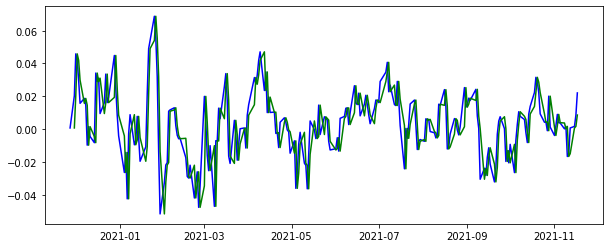

In [198]:
# log_moving_avg7 과 log_moving_avg7를 시프트한 시계열 그래프 시각화
ts_log_moving_avg_shift = ts_log_moving_avg7.shift()
fig, ax = plt.subplots(figsize=(10, 4))
plt.plot(ts_log_moving_avg7, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

- 원본 시계열에서 시프트한 시계열을 뺀 값을 그래프로 표현해 봅시다.

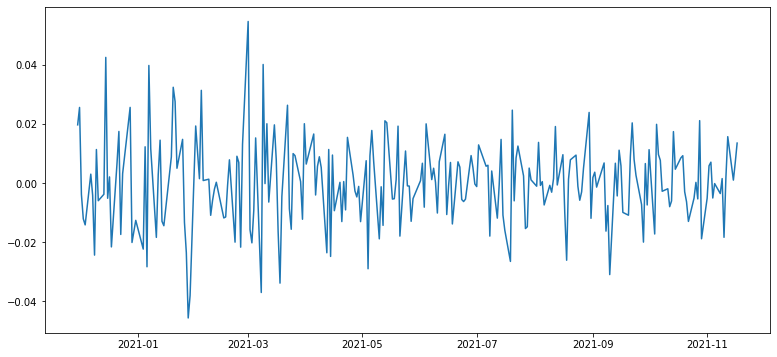

In [199]:
ts_log_moving_avg_diff = ts_log_moving_avg7 - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

## STEP 3. 시계열 안정성 분석
---
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

### 3-1. 정성적 그래프 분석

- 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악

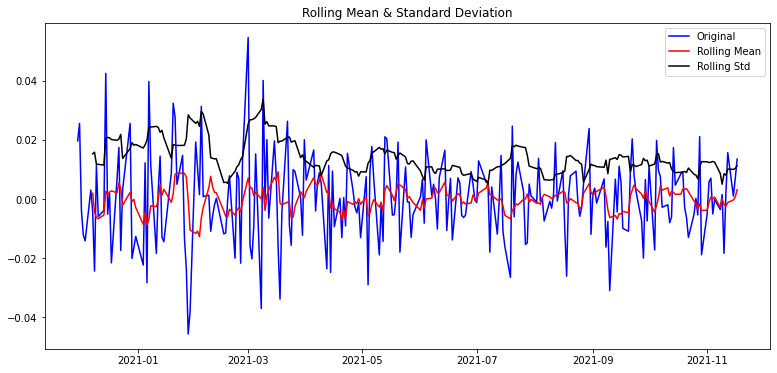

In [201]:
# 이동평균과, 이동표준편차를 그래프에 나타내어 정성적으로 안정성(stationary) 여부를 파악
plot_rolling_statistics(ts_log_moving_avg_diff)

### 3-2. 정량적 Augmented Dicky-Fuller Test
- 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행

In [202]:
# 차분의 효과가 어떠했는지 알아보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -5.285292
p-value                          0.000006
#Lags Used                      16.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


이동평균을 빼 주어 추세(Trend)를 제거하고 난 시계열에다가

1차 차분(1st order differencing)을 적용하여 Seasonality 효과를 다소 상쇄한 결과,

p-value가 1.649586e-09 로 매우 작은 값으로 줄었음을 확인 할 수 있습니다.

### 3-3. 시계열 분해(Time Series Decomposition)

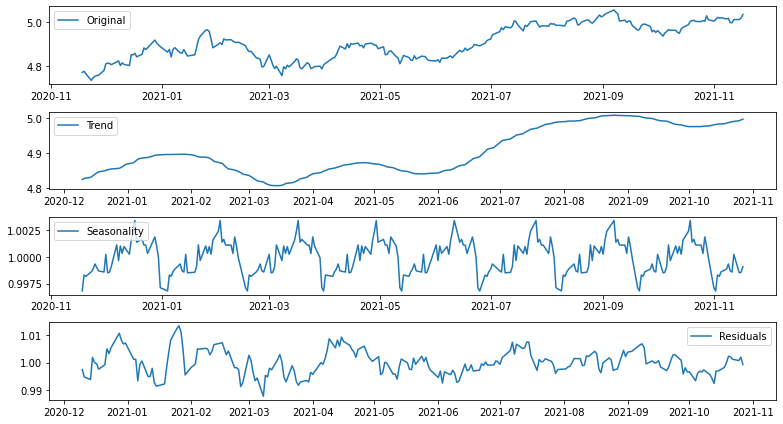

In [203]:
#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다.

뒤집어서 말하면 Trend+Seasonality+Residual=Original 이 성립한다는 뜻입니다.

이러한 Decomposing은 시계열 데이터를 이해하는 중요한 관점을 제시해 줍니다.

그렇다면 이제 Residual에 대해 안정성 여부를 따져 봅시다.

### 3-4. Residual 안정성 확인

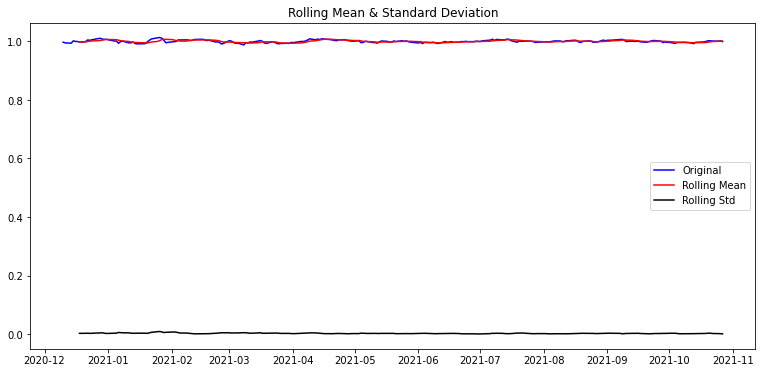

In [204]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [205]:
# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -5.332912
p-value                          0.000005
#Lags Used                       0.000000
Number of Observations Used    221.000000
Critical Value (1%)             -3.460291
Critical Value (5%)             -2.874709
Critical Value (10%)            -2.573789
dtype: float64


Decomposing을 통해 얻어진 Residual은 낮은 p-value를 보여 줍니다.

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있겠습니다.

어쩌면 굳이 애써 직접 Trend, Seasonality를 제거하려고 애쓸 필요가 없이 바로 Time Series Decomposing을 시도하는 게 더 낫지 않았을까 싶긴 하겠다만, 이렇게 Trend와 Seasonality를 제거해 주는 것이 어떤 효과를 발휘하게 되는지를 단계적으로 확인하는 과정이었다고 할 수 있겠습니다.

## STEP 4. 학습, 테스트 데이터셋 생성
---
- 학습, 테스트 데이터셋을 9 : 1 비율로 분리

In [206]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]

In [207]:
print(len(train_data))
print(len(test_data))

226
26


- 학습 데이터와 테스트 데이터가 227, 26개로 분리 되었음을 확인 할 수 있습니다.

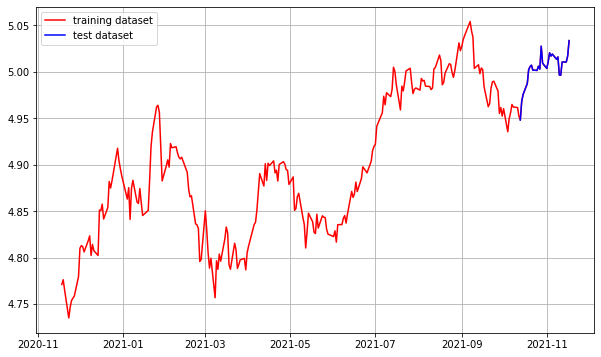

In [208]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## STEP 5. 적정 ARIMA 모수 찾기
---
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

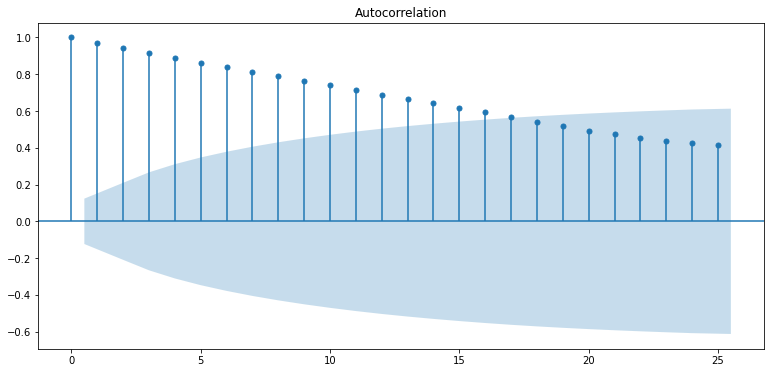

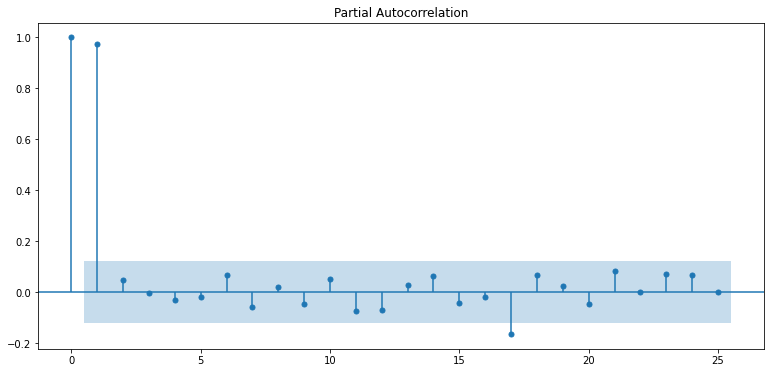

In [209]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

위의 그래프의 결론을 내려보자면,

- ACF 그래프를 보면,1에서 25로 갈수록 1에서 0.4로 수렴함을 확인 할 수 있으므로, 적합한 q(MA 모델의 시차) 값이 없을 것 같습니다. 우선 q = 0 으로 진행해 보겠습니다.

- PACF 그래프를 보면 p (AR 모델의 시차) = 1 이 매우 적합할 것으로 보입니다. P가 2 이상인 구간에서 PACF는 거의 0에 가까워 지고 있기 때문입니다. (PACF가 0 이라는 의미는 현재 데이터와 p 시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻입니다.)

Results of Dickey-Fuller Test:
Test Statistic                -1.648301e+01
p-value                        2.228167e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.500000e+02
Critical Value (1%)           -3.456781e+00
Critical Value (5%)           -2.873172e+00
Critical Value (10%)          -2.572969e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.499167e+00
p-value                        1.173563e-08
#Lags Used                     1.600000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


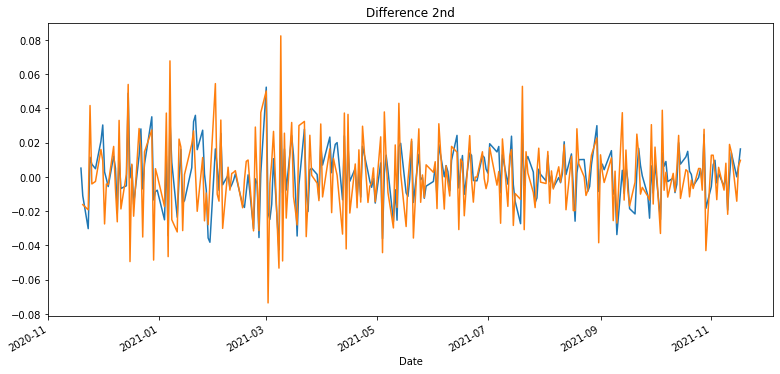

In [210]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

d = 1 일 때나 d = 2 일 때, 모두  p-value 가 각각 2.228167e-29, 1.173563e-08 와 로 매우 안정화 상태를 보였습니다.

하지만, d = 0 부터 먼저 시도해 보고, d 값을 바꿔가면서 최적의 값을 찾아보도록 하겠습니다.

## STEP 6. ARIMA 모델 훈련과 테스트
---
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

In [211]:
import warnings
warnings.filterwarnings('ignore') #경고 무시

from statsmodels.tsa.arima_model import ARIMA

#### (1) p=1, d=0, q=0

In [212]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 0, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  226
Model:                     ARMA(1, 0)   Log Likelihood                 612.607
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 18 Nov 2021   AIC                          -1219.214
Time:                        16:48:50   BIC                          -1208.952
Sample:                             0   HQIC                         -1215.072
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           4.8851      0.044    111.901      0.000       4.800       4.971
ar.L1.Close     0.9795      0.013     76.835      0.000       0.954       1.004
                                    Roots       

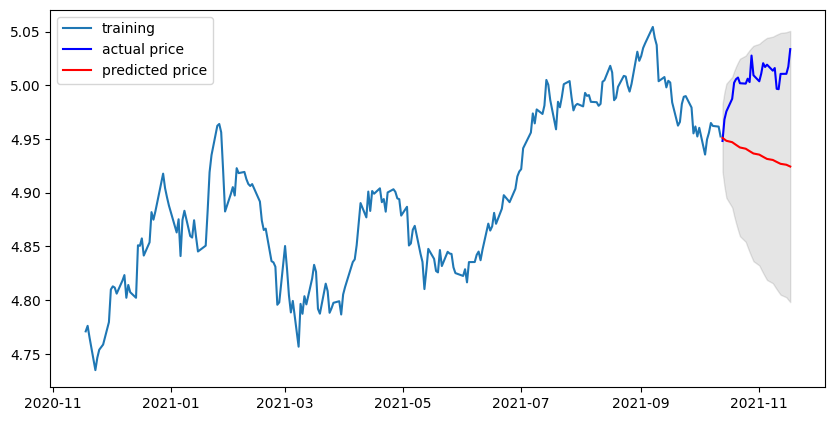

In [213]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [214]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  107.72748720267649
MAE:  9.798425128651253
RMSE:  10.379185286075034
MAPE: 6.54%


- 예측 모델의 메트릭으로 활용하기에 나쁘지 않은 MAPE 기준으로 6.54% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (2) p=1, d=1, q=0

In [215]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 610.972
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 18 Nov 2021   AIC                          -1215.943
Time:                        16:51:42   BIC                          -1205.695
Sample:                             1   HQIC                         -1211.807
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.792      0.428      -0.001       0.003
ar.L1.D.Close    -0.0476      0.067     -0.716      0.474      -0.178       0.083
                                    Root

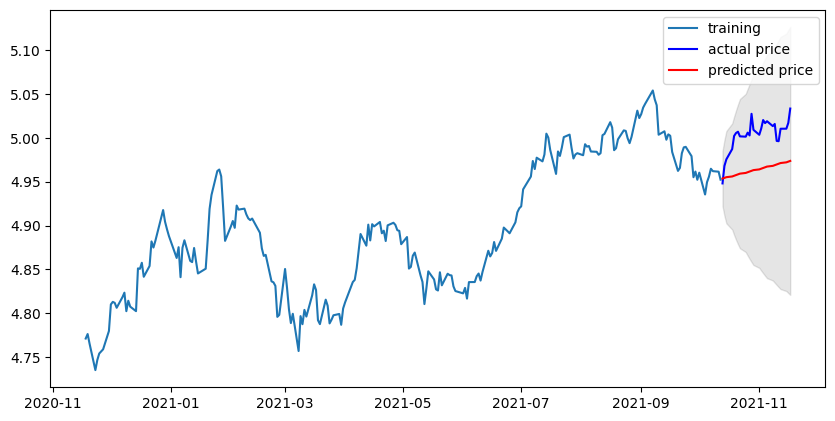

In [216]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [217]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  39.83158664042823
MAE:  5.995443557061619
RMSE:  6.311227031285456
MAPE: 4.00%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 나쁘지 않은 MAPE 기준으로 4.00% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (3) p=1, d=2, q=0

In [218]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 558.435
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 18 Nov 2021   AIC                          -1110.871
Time:                        16:53:21   BIC                          -1100.636
Sample:                             2   HQIC                         -1106.740
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -2.675e-05      0.001     -0.030      0.976      -0.002       0.002
ar.L1.D2.Close    -0.5090      0.057     -8.881      0.000      -0.621      -0.397
                                    

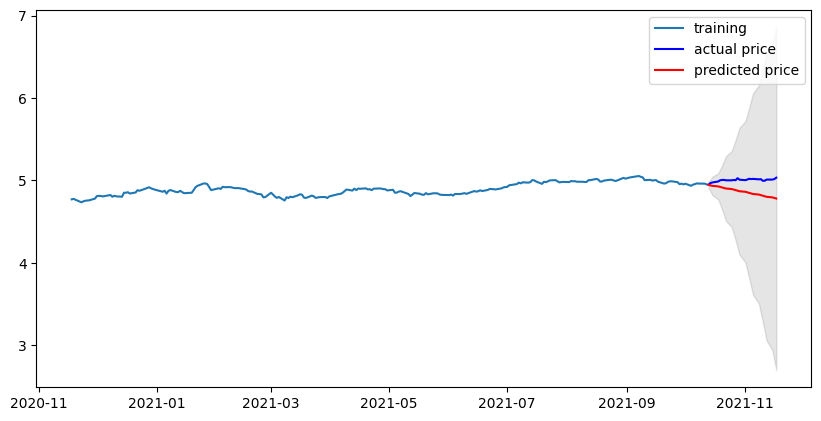

In [219]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [220]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  441.1373882613033
MAE:  19.208210561925092
RMSE:  21.00327089434651
MAPE: 12.80%


- 예측 모델의 메트릭으로 활용하기에 나쁘진 않지만 MAPE 기준으로 12.80% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (4) p=0, d=1, q=0

In [221]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 1, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 610.716
Method:                           css   S.D. of innovations              0.016
Date:                Thu, 18 Nov 2021   AIC                          -1217.431
Time:                        16:55:00   BIC                          -1210.599
Sample:                             1   HQIC                         -1214.674
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.001      0.755      0.451      -0.001       0.003


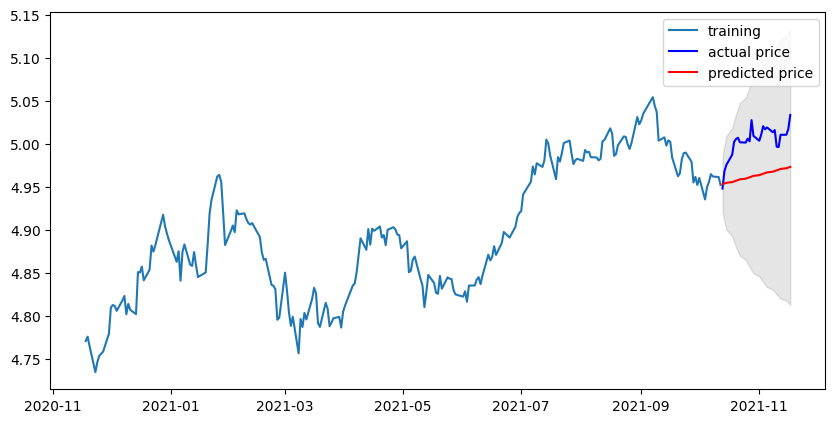

In [222]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [223]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  40.63314542946361
MAE:  6.057293975413192
RMSE:  6.374413340023034
MAPE: 4.04%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 나쁘지 않은 MAPE 기준으로 4.04% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (5) p=0, d=1, q=1

In [224]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 610.988
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 18 Nov 2021   AIC                          -1215.975
Time:                        16:56:15   BIC                          -1205.727
Sample:                             1   HQIC                         -1211.839
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.001      0.797      0.425      -0.001       0.003
ma.L1.D.Close    -0.0507      0.069     -0.737      0.461      -0.186       0.084
                                    Root

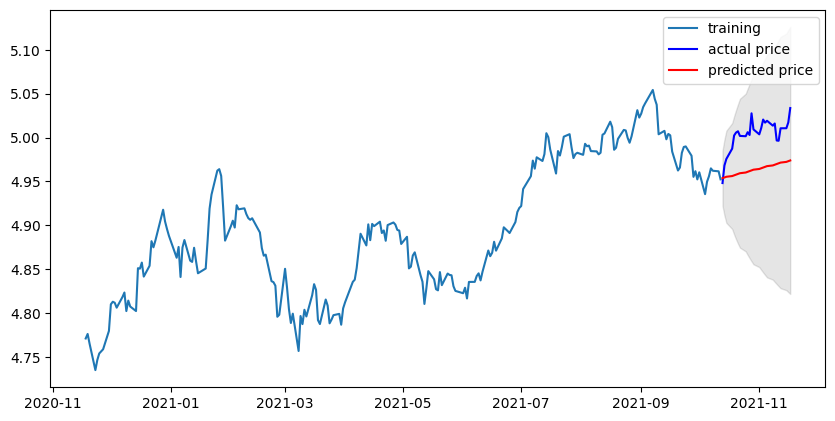

In [225]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [226]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  39.72774594947889
MAE:  5.987261621515101
RMSE:  6.3029949983701306
MAPE: 4.00%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 나쁘지 않은 MAPE 기준으로 4.04% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (6) p=0, d=2, q=0

In [227]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 2, 0))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(0, 2, 0)   Log Likelihood                 524.758
Method:                           css   S.D. of innovations              0.023
Date:                Thu, 18 Nov 2021   AIC                          -1045.515
Time:                        16:57:25   BIC                          -1038.692
Sample:                             2   HQIC                         -1042.761
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.384e-05      0.002     -0.041      0.967      -0.003       0.003


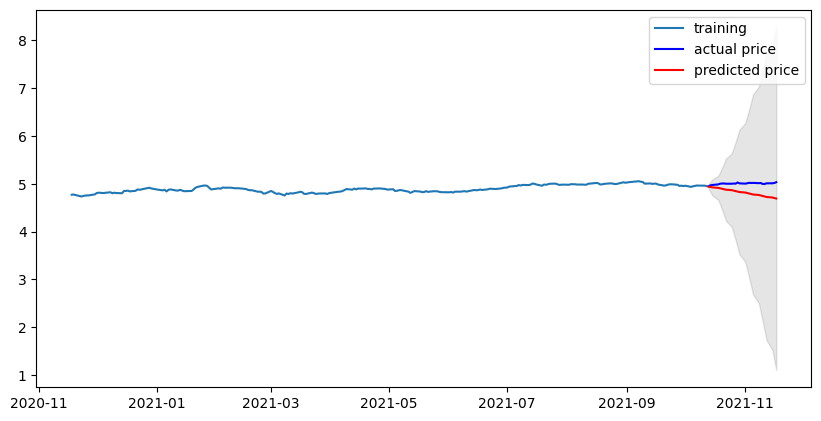

In [228]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [229]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  734.9294078142156
MAE:  24.638861008087808
RMSE:  27.10958147619058
MAPE: 16.43%


- 예측 모델의 메트릭으로 활용하기에 많이 미흡한 MAPE 기준으로 16.43% 정도의 오차율을 보입니다.

- 더 적당한 모수를 찾을 수 있다면 개선의 여지가 있을 수도 있으니, 조금만 더 시도해 보도로 하겠습니다.

#### (7) p=0, d=2, q=1

In [230]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(0, 2, 1))  
fitted_m = model.fit()  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:               D2.Close   No. Observations:                  224
Model:                 ARIMA(0, 2, 1)   Log Likelihood                 604.911
Method:                       css-mle   S.D. of innovations              0.016
Date:                Thu, 18 Nov 2021   AIC                          -1203.821
Time:                        16:58:43   BIC                          -1193.586
Sample:                             2   HQIC                         -1199.690
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -7.955e-06   1.65e-05     -0.483      0.629   -4.03e-05    2.43e-05
ma.L1.D2.Close    -1.0000      0.014    -74.059      0.000      -1.026      -0.974
                                    

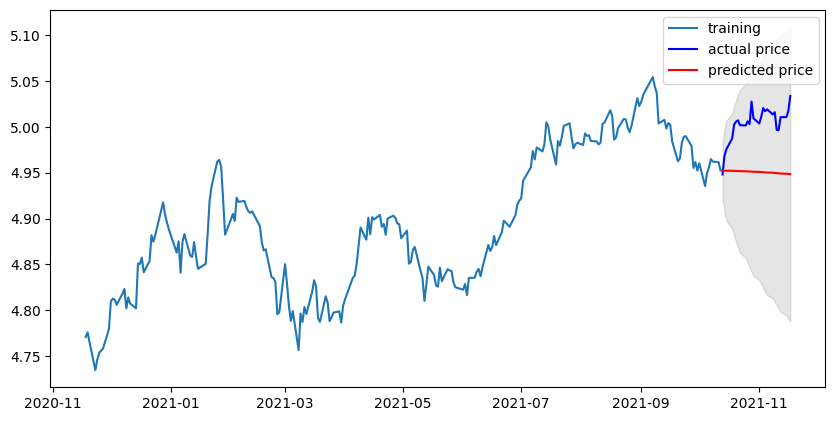

In [231]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [232]:
# 최종 예측 모델 정확도 측정(MAPE)

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  68.01702394838966
MAE:  7.825426855877376
RMSE:  8.247243415129061
MAPE: 5.22%


- 앞에서 진행한 모델보다는 성능이 향상 되었지만, 예측 모델의 메트릭으로 활용하기에 나쁘지 않은 MAPE 기준으로 5.22% 정도의 오차율을 보입니다.

### 정리

- (1) p=1, d=0, q=0 -> MAPE: 6.54%

- (2) p=1, d=1, q=0 -> MAPE: 4.00%

- (3) p=1, d=2, q=0 -> MAPE: 12.80%

- (4) p=0, d=1, q=0 -> MAPE: 4.04%

- (5) p=0, d=1, q=1 -> MAPE: 4.00%

- (6) p=0, d=2, q=0 -> MAPE: 16.43%

- (7) p=0, d=2, q=1 -> MAPE: 5.22%

### Apple ARIMA 모델 최적의 MAPE 결과
- p=1, d=1, q=0 와 p=0, d=1, q=1 일 때, 4.00%의 정도의 오차율을 보임을 알 수 있었습니다.

## 7-4. 결과 정리 (목표 : MAPE 15% 미만의 정확도로 예측되었는가?)

### Samsung : ARIMA 모델 p=1, d=0, q=0 일 때, 1.40%의 정도의 오차율을 보임을 알 수 있었습니다. (목표 달성!)

### Tesla : ARIMA 모델 p=0, d=2, q=0 일 때, 15.02%의 정도의 오차율을 보임을 알 수 있었습니다. (목표에 근사함.)

### Nvidia : ARIMA 모델 p=0, d=2, q=1 일 때, 15.07%의 정도의 오차율을 보임을 알 수 있었습니다. (목표에 근사함.)

### Apple : ARIMA 모델 p=1, d=1, q=0 와 p=0, d=1, q=1 일 때, 4.00%의 정도의 오차율을 보임을 알 수 있었습니다. (목표 달성!)


# STEP 8. 루브릭 & 회고
---

## 루브릭

1. 시계열의 안정성이 충분히 확인되었는가?  

    - 플로팅과 adfuller 메소드가 모두 적절히 사용되었음  
    
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?  

    - p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨  

3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

    - 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨  
    
## 회고

- 개인적으로 재태크에 흥미가 있던지라, 꽤나 관심이 있는 주제인 프로젝트라고 생각하고 접근했었던 프로젝트라고 생각합니다.

- 하지만, 제가 통계에 대한 지식이 부족했던 이유인지, 아니면 시계열을 해석하는 능력이 부족했던 이유인지는 모르겠지만, 생각보다 MAPE 15% 미만의 정확도를 예측하기가 어려웠습니다.

- 개인적으로 모델의 정확도를 높이기 위해서는 적절한 window 값을 설정하는 것과, p-value값을 낮춰 안정성이 있는 그래프를 생성하고, 주식에 따른 적절한ARIMA 모수를 찾는 것이 중요하다는 사실을 인지하고 위의 적절한 window 값을 설정과 p-value값을 낮춰 안정성이 있는 그래프를 생성하는 것까지는 잘 진행했었던 거 같은데...

- 개인적으로 적절한 ARIMA 모수를 찾는 것은 어려운 작업이었다고 생각합니다. ARIMA 모수를 찾기 위해서, 노드에 나온대로, 로그 변환 값과 1차 차분, 2차 차분 값 등등을 모두 이용하고 각각의 데이터를 이용하여 ACF와 PACF 그래프를 그렸고, 모든 데이터를 종합적으로 판단하여 ARIMA 모수(p, d, q)를 결정하고자 하였지만, 모수를 선정하는 것이 너무 어려웠습니다...

- 그리고, Tesla 와 Nvidia 주식에서 원하는 MAPE가 나오지 않아서 무지성으로 코드 복붙 & 오로지 MAPE를 낮추기 위한 생각만을 하다가, ARIMA 모델에서 모수를 찾을 때의 주의 사항 (p + q < 2, p * q= 0)을 생각하지 못하고 있다가 조언을 해주신 성연님에게 이자리에서 감사하다는 인사를 드리고 싶습니다.

- 노드에 있는 내용을 따라 내려가는 것은 좋지만, 거기에 나온 개념의 이해와 코드 작성 과정에서 내가 이 코드를 사용하는 것에 대한 이유를 생각해야만 한다는 사실을 다시 한 번 느끼게 해준 노드라고 생각합니다.

- 이번 프로젝트의 교훈 : '무지성 코드 복붙을 하지 말자!, 노드에서 나온 개념을 정확히 숙지 후 프로젝트를 진행하자!'